In [2]:
import xarray as xr
import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

import metpy.calc as mpcalc
from metpy.units import units
from metpy.interpolate import cross_section
import cartopy.crs as ccrs
import matplotlib.colors as mcolors
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from geocat.viz import cmaps as gvcmaps
from geocat.comp import dpres_plevel

import xesmf as xe  
import matplotlib
matplotlib.__version__
#mpcalc.q_vector
#mpcalc.ageostrophic_wind

import warnings
warnings.filterwarnings(action='ignore') # action='default'

In [140]:
datadir = "/mnt/e/Dropbox/02_Researchs/07_COAWST_Lingling/data/"
#datadir = "/mnt/c/Users/YANG-desktop/Dropbox/02_Researchs/07_COAWST_Lingling/data/"

# locations of the cross-line
cross_start, cross_end = (35, 123), (31, 129)
#cross_start, cross_end = (36, 126), (28, 126)

lonW, latS, lonE, latN = [cross_start[1]-1, cross_end[0]-1, cross_end[1]+1, cross_start[0]+1]

# draw filled contours.
clevs = [0, 1, 2.5, 5, 7.5, 10, 15, 20, 30, 40,
         50, 70, 100, 150, 200, 250, 300, 400, 500, 600, 750]
clevs = [ c/5 for c in clevs]
# In future MetPy
# norm, cmap = ctables.registry.get_with_boundaries('precipitation', clevs)
cmap_data = [(1.0, 1.0, 1.0),
             (0.3137255012989044, 0.8156862854957581, 0.8156862854957581),
             (0.0, 1.0, 1.0),
             (0.0, 0.8784313797950745, 0.501960813999176),
             (0.0, 0.7529411911964417, 0.0),
             (0.501960813999176, 0.8784313797950745, 0.0),
             (1.0, 1.0, 0.0),
             (1.0, 0.6274510025978088, 0.0),
             (1.0, 0.0, 0.0),
             (1.0, 0.125490203499794, 0.501960813999176),
             (0.9411764740943909, 0.250980406999588, 1.0),
             (0.501960813999176, 0.125490203499794, 1.0),
             (0.250980406999588, 0.250980406999588, 1.0),
             (0.125490203499794, 0.125490203499794, 0.501960813999176),
             (0.125490203499794, 0.125490203499794, 0.125490203499794),
             (0.501960813999176, 0.501960813999176, 0.501960813999176),
             (0.8784313797950745, 0.8784313797950745, 0.8784313797950745),
             (0.9333333373069763, 0.8313725590705872, 0.7372549176216125),
             (0.8549019694328308, 0.6509804129600525, 0.47058823704719543),
             (0.6274510025978088, 0.42352941632270813, 0.23529411852359772),
             (0.4000000059604645, 0.20000000298023224, 0.0)]
cmap = mcolors.ListedColormap(cmap_data, 'precipitation')
norm = mcolors.BoundaryNorm(clevs, cmap.N)

In [4]:
def regrid_wrf2rect(infile):
    
    data = xr.open_dataset(infile).metpy.parse_cf()
    
    dx, dy = mpcalc.lat_lon_grid_deltas(data.lon * units("degrees_E"), data.lat * units("degrees_N"))
    
    x_dim, y_dim, vertical_dim = [3, 2, 1]
    nlev = len(data.level.values)
    ntime = len(data.Time.values)
    dx, dy = [np.tile(dx, (ntime,nlev,1,1)), np.tile(dy, (ntime,nlev,1,1))]
    
    print('calc eth2')
    data['eth2'] = mpcalc.equivalent_potential_temperature(data.slp * units.hPa, 
                                                    data.T2 * units.degC, 
                                                    data.td2 * units.degC)
    
    data['div'] = mpcalc.divergence(u=data.ua * units['m/s'], v=data.va * units['m/s'],
                                    dx=dx, dy=dy, x_dim=x_dim, y_dim=y_dim)
    
    tmp = mpcalc.first_derivative(data.th * units.kelvin, axis=2, delta=dy)
    data['th_grad_y'] = xr.DataArray(tmp, coords=data.th.coords, dims=data.th.dims)
    
    tmp = mpcalc.first_derivative(data.eth * units.kelvin, axis=2, delta=dy)
    data['eth_grad_y'] = xr.DataArray(tmp, coords=data.eth.coords, dims=data.eth.dims)
    
    data['sh'] = mpcalc.specific_humidity_from_dewpoint(pressure=data.p * units.hPa, dewpoint=data.td * units.degC)
    
    data['mfc_adv'] = mpcalc.advection(scalar=data.sh, u=data.ua * units['m/s'], v=data.va * units['m/s'],
                           dx=dx, dy=dy, x_dim=x_dim, y_dim=y_dim, vertical_dim=vertical_dim)
    
    data['mfc_conv'] = -data.sh* mpcalc.divergence(u=data.ua * units['m/s'], v=data.va * units['m/s'],
                           dx=dx, dy=dy, x_dim=x_dim, y_dim=y_dim)
    
    data['mfc'] = data.mfc_adv + data.mfc_conv
    
    data['fr'] = mpcalc.frontogenesis(data.th * units.kelvin, data.ua * units['m/s'], data.va * units['m/s'],
                          dx=dx, dy=dy, x_dim=x_dim, y_dim=y_dim)
    mpcalc.total_deformation

    return data, dx, dy

# Preprocessing

## Open dataset using xarray

In [5]:
ds1 = xr.open_dataset(datadir+"/metpy_wrfout_Lingling_NOCPL_final_cape.nc").metpy.parse_cf()
ds2 = xr.open_dataset(datadir+"/metpy_wrfout_Lingling_CPL_nodown_final_cape.nc").metpy.parse_cf()
ds3 = xr.open_dataset(datadir+"/metpy_wrfout_Lingling_CPL_down_final_cape.nc").metpy.parse_cf()
ds2

<xarray.Dataset>
Dimensions:             (Time: 67, lon: 201, lat: 151, level: 19, low_mid_high: 3, mcape_mcin_lcl_lfc: 4, cape_cin: 2)
Coordinates:
  * Time                (Time) datetime64[ns] 2019-09-06 ... 2019-09-08T18:00:00
  * lon                 (lon) float64 116.0 116.1 116.2 ... 135.8 135.9 136.0
  * lat                 (lat) float64 27.0 27.1 27.2 27.3 ... 41.8 41.9 42.0
    metpy_crs           object Projection: latitude_longitude
  * level               (level) int64 1000 950 900 850 800 ... 250 200 150 100
  * low_mid_high        (low_mid_high) object 'low' 'mid' 'high'
  * mcape_mcin_lcl_lfc  (mcape_mcin_lcl_lfc) object 'mcape' 'mcin' 'lcl' 'lfc'
  * cape_cin            (cape_cin) object 'cape' 'cin'
Data variables: (12/38)
    PSFC                (Time, lat, lon) float64 ...
    SST                 (Time, lat, lon) float64 ...
    U10                 (Time, lat, lon) float64 ...
    V10                 (Time, lat, lon) float64 ...
    HFX                 (Time, lat, lon) float64 ...
    LH                  (Time, lat, lon) float64 ...
    ...                  ...
    omg                 (Time, level, lat, lon) float64 ...
    geopt               (Time, level, lat, lon) float64 ...
    cape_3d             (cape_cin, Time, level, lat, lon) float64 ...
    wspd                (Time, level, lat, lon) float64 ...
    latitude            (lat, lon) float64 ...
    longitude           (lat, lon) float64 ...
Attributes:
    regrid_method:  bilinear

# Create figure and subpanels

## Background:
  - Air-sea coupling has no significant changes in both intensity and its trajectory of Typhoon Lingling
  - The oceanic response affects precipitation changes after the typhoon has passed
  
### Analysis variables: 
   - 12-hr cumulative precipitation field
   - mid-level tropospheric (500 hPa) omega to low-level tropospheric (850 hPa) temperature gradient
   - low-to-mid cloud fraction to low-tropospheric (850 hPa) temperature gradient
   - 950-700 hPa vertically integrated moisture flux convergence to 1000 hPa frontogenesis
   - cross-section of eth, frontogenesis, qvapor, etc.

### Previous studies:
#### Kim et al. (2021, JGR): 
  - Unlike the uncoupled model, the SST simulated by the coupled model dramatically decreased and maintained its low temperature for more than a week after the typhoon passed over the YS, showing better agreement with the observations. The sharp SST decrease over the YS cools the air temperature at low-level atmosphere and enhances horizontal convergence in the moisture flux over the cooler ocean, which provides favorable conditions for sea fog formation. The long-lasting oceanic cooling stabilizes the atmospheric boundary layer and suppresses atmospheric vertical mixing, delaying the dissipation of sea fog for more than a week. This study highlights that air-sea coupling can improve the sea fog simulation by providing more realistic oceanic conditions.

## Interpretation of Frontogenesis:

### what is frontogenesis?
- Frontogenesis is very useful for assessing the potential for mesoscale banded precipitation zones.
- Frontogenesis produces a mesoscale direct thermal circulation that is sloped with height toward cold air (add referecne).
- Deformation and convergence creating frontogenetical forcing north of the warm front result in a band of precipitation.
- Positive frontogenesis increases due to convergence oriented nearly perpendicular to a thermal gradient.
       
### contributing factors
1) tilting effects: Vertical motion acts to increase the thermal gradient.
2) diabatic heating: Cloud cover is limiting radiational warming on colder left side, while cloud-free warm area on right heats up. Thus, thermal gradient strengthens (frontogenetical). 

### research question
- The downward latent heat flux amplifies the tropospheric response to synoptic scale fields through the air-sea coupling?

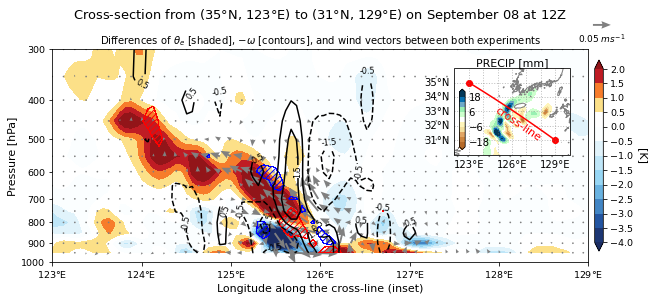

In [649]:
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False),
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = mcolors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

proj = ccrs.PlateCarree()
nrows, ncols = [1, 1]
fig, ax = plt.subplots(nrows, ncols, figsize=(9,4), constrained_layout=True)

#title = r"Cross-section from (35$\degree$N, 123$\degree$E) to (31$\degree$N, 129$\degree$E) on September 08 at 1200Z"
#fig.suptitle(title, fontsize=13)
title = r"Cross-section from (35$\degree$N, 123$\degree$E) to (31$\degree$N, 129$\degree$E) on September 08 at 12Z"
ax.text(x=0.5, y=1.12, s=title, fontsize=13, ha='center',va='bottom', transform=ax.transAxes)


#ax.text(x=0.5, y=1.1, s=title, fontsize=13, ha='center',va='bottom', transform=ax.transAxes)
#title = r"Cross-section on 8 September 2019, 1200UTC"
title = r'Differences of $\theta_{e}$ [shaded], $-\omega$ [contours], and wind vectors between both experiments'
ax.set_title(title, fontsize=10)


t=60
tds2 = ds2.isel(Time=t, level=slice(1,15))
tds3 = ds3.isel(Time=t, level=slice(1,15))

tds = tds3
dx, dy = mpcalc.lat_lon_grid_deltas(tds.lon * units("degrees_E"), 
                                    tds.lat * units("degrees_N"))
nlev = len(tds.level.values)
dx, dy = [np.tile(dx, (nlev,1,1)), np.tile(dy, (nlev,1,1))]

tds2['fr'] = mpcalc.frontogenesis(tds2.th * units.kelvin, 
                              tds2.ua * units['m/s'], 
                              tds2.va * units['m/s'], 
                              dx=dx, dy=dy)
tds2['omg'] = mpcalc.smooth_n_point(tds2.omg, 9)
tds2['eth'] = mpcalc.smooth_n_point(tds2.eth, 9)
sh = mpcalc.specific_humidity_from_dewpoint(pressure=tds2.p * units.hPa, 
                                                dewpoint=tds2.td * units.degC)
tds2['ua'] = mpcalc.smooth_n_point(tds2.ua, 9)
tds2['qu'] = mpcalc.smooth_n_point(sh, 9)* tds2.ua *1000 # g kg-1 m s-1
tds2['va'] = mpcalc.smooth_n_point(tds2.va, 9)
tds2['qv'] = mpcalc.smooth_n_point(sh, 9)* tds2.va *1000 # g kg-1 m s-1

tds3['fr'] = mpcalc.frontogenesis(tds3.th * units.kelvin, 
                              tds3.ua * units['m/s'], 
                              tds3.va * units['m/s'], 
                              dx=dx, dy=dy)
tds3['omg'] = mpcalc.smooth_n_point(tds3.omg, 9)
tds3['eth'] = mpcalc.smooth_n_point(tds3.eth, 9)
sh = mpcalc.specific_humidity_from_dewpoint(pressure=tds3.p * units.hPa, 
                                                dewpoint=tds3.td * units.degC)
tds3['ua'] = mpcalc.smooth_n_point(tds3.ua, 9)
tds3['qu'] = mpcalc.smooth_n_point(sh, 9)* tds3.ua *1000 # g kg-1 m s-1
tds3['va'] = mpcalc.smooth_n_point(tds3.va, 9)
tds3['qv'] = mpcalc.smooth_n_point(sh, 9)* tds3.va *1000 # g kg-1 m s-1 => m s-1

cross2 = cross_section(tds2, cross_start, cross_end).set_coords(('lat','lon'))
cross2['t_wind'], cross2['n_wind'] = mpcalc.cross_section_components(cross2['qu'], cross2['qv'])

cross3 = cross_section(tds3, cross_start, cross_end).set_coords(('lat','lon'))
cross3['t_wind'], cross3['n_wind'] = mpcalc.cross_section_components(cross3['qu'], cross3['qv'])

cross = cross3 - cross2

cmap=gvcmaps.BlueWhiteOrangeRed
shifted_cmap = shiftedColorMap(cmap, midpoint=0.7, name='shifted')
cf = ax.contourf(cross['lon'], cross['level'], cross['eth'],
        levels=np.arange(-4,2.5,0.5), cmap=shifted_cmap, extend='both')
cbar = fig.colorbar(cf, ax=ax, shrink=0.9, aspect=20, pad=-0.015, ticks=np.arange(-4,2.5,0.5))
cbar.set_label('[K]', fontsize=11, rotation=-90, va='bottom')
cbar.ax.tick_params(labelsize=9.5)
cbar.ax.tick_params(which='minor', length=0)

cs_levs = np.arange(-3.5,4.5,1)
cs = ax.contour(cross['lon'], cross['level'], -cross['omg'],
        levels=cs_levs[np.where(cs_levs!=0)], colors='k', linewidths=1.5)
ax.clabel(cs, fontsize=8, inline=1, inline_spacing=1, fmt='%0.1f')

skip = slice(None,None, 2)
q = ax.quiver(cross['lon'][skip], cross['level'][:],
        cross['t_wind'][:,skip], cross['n_wind'][:,skip],
        headwidth=4, width=0.0035, scale=1500, color='grey')
ax.quiverkey(q, X=1.025, Y=1.115, U=50, 
             label=r'0.05 $ms^{-1}$', labelpos='S',
             fontproperties=dict(size=9))

clL = ax.contourf(cross['lon'], cross['level'], cross['fr']*1e9, levels=[-1000,-5], hatches=['////'], colors='none')
for i, collection in enumerate(clL.collections):
        collection.set_edgecolor('b')
        collection.set_linewidth(0.1)
clU = ax.contourf(cross['lon'], cross['level'], cross['fr']*1e9, levels=[5,1000], hatches=['////'], colors='none')
for i, collection in enumerate(clU.collections):
        collection.set_edgecolor('r')
        collection.set_linewidth(0.1)

# Adjust the y-axis to be logarithmic
ax.set_yscale('symlog')
ax.set_yticklabels(np.arange(1000, 200, -100))
ax.set_yticks(np.arange(1000, 200, -100))
ax.set_ylim(1000,300)
ax.set_ylabel('Pressure [hPa]', fontsize=11)

ax.set_xticks(np.arange(123,130,1))
ax.set_xticklabels([ r"{:d}$\degree$E".format(i) for i in np.arange(123,130,1)])
ax.set_xlabel('Longitude along the cross-line (inset)', fontsize=11)
ax.tick_params(labelsize=9.5)

#-----------------------------------
# Define the CRS and inset axes
data = ds3.isel(Time=t)-ds2.isel(Time=t)
data_crs = data['accrain_12h'].metpy.cartopy_crs
ax_inset = fig.add_axes([0.635, 0.49, 0.3, 0.3], projection=data_crs)
gl = ax_inset.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle=':')
gl.xlabels_top, gl.xlabels_bottom, gl.ylabels_left, gl.ylabels_right = [False, True, True, False]
gl.xformatter, gl.yformatter = [LONGITUDE_FORMATTER, LATITUDE_FORMATTER]
ax_inset.tick_params(labelsize=8)
cf = ax_inset.contourf(data['lon'], data['lat'], mpcalc.smooth_n_point(data['accrain_12h'], 9),
        levels=np.arange(-22,26,4), cmap=gvcmaps.precip_diff_12lev, extend='both')
axins = inset_axes(ax_inset, width="5%", height="70%", loc='lower left')
cbar = fig.colorbar(cf, cax=axins, orientation="vertical", ticks=[-18,-6,6,18])
cbar.ax.tick_params(which='both', direction='in')
cbar.ax.tick_params(which='both', length=0)

#ax_inset.plot(obs_lon, obs_lat, color='k', ms=10, marker='*', zorder=100, alpha=0.5 )
ax_inset.scatter([cross_start[1],cross_end[1]], [cross_start[0],cross_end[0]], c='r', zorder=2)
ax_inset.plot(cross['lon'], cross['lat'], c='r', zorder=2)

ax_inset.text(0.5, 1.005, s=r'PRECIP [mm]', color='k', fontsize=11, ha='center', va='bottom',
        transform=ax_inset.transAxes)
ax_inset.text(0.55, 0.35, s='cross-line', color='r', fontsize=11, ha='center', va='center',
        transform=ax_inset.transAxes, rotation=-34)

ax_inset.coastlines(color='grey')
#ax_inset.add_feature(cfeature.LAND.with_scale('50m'), edgecolor='k', alpha=0.2, zorder=0)
ax_inset.set_extent([cross_start[1]-1, cross_end[1]+1, cross_end[0]-1, cross_start[0]+1])
#-----------------------------------

fig.savefig('rev_fig_08_cross.png', dpi=500, bbox_inches='tight')

#ax.text(x=0.015, y=1.0075, s='a', fontsize=15, weight='bold', ha='center',va='bottom', transform=ax.transAxes)


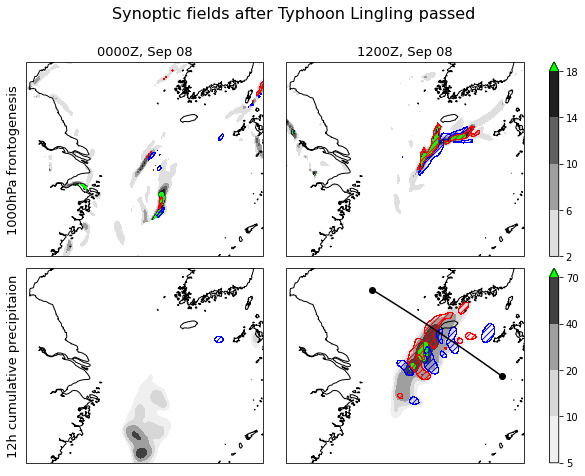

In [650]:
def calc_frontogenesis(ds, t=0, level=0):
    ds = ds.isel(Time=t)
    dx, dy = mpcalc.lat_lon_grid_deltas(ds.lon * units("degrees_E"), 
                                        ds.lat * units("degrees_N"))
    nlev = len(ds.level.values)
    dx, dy = [np.tile(dx, (nlev,1,1)), np.tile(dy, (nlev,1,1))]

    fr = mpcalc.frontogenesis(ds.th * units.kelvin, 
                              ds.ua * units['m/s'], 
                              ds.va * units['m/s'], 
                              dx=dx, dy=dy).isel(level=level)*1e9
    
    return([fr, ds.lat, ds.lon])

proj = ccrs.PlateCarree()
nrows, ncols = [2, 2]
fig, axes = plt.subplots(nrows, ncols, figsize=(8,6.5), constrained_layout=True, 
                        subplot_kw=dict(projection=proj))

fig.suptitle('Synoptic fields after Typhoon Lingling passed\n', fontsize=16)

for ax in axes.flatten():
    ax.coastlines()
    #ax.set_extent([118, 129, 27, 41], crs=proj)
    ax.set_extent([119, 130, 27, 36], crs=proj)
    #ax.set_extent([lonW, lonE, latS, latN], crs=proj)

Tlevel = np.arange(2,20,4)
Blevel = [5, 10, 20, 40, 70]
cmap = gvcmaps.gsltod
cmap.set_over('lime')

for col, t in enumerate([48, 60]):
    ax = axes[0,col]
    ax.set_title(ds3['Time'].isel(Time=t).dt.strftime("%H00Z, %b %d").values, 
                 fontsize=13, loc='center')

    fr3, lat, lon = calc_frontogenesis(ds=ds3, t=t, level=0)
    fr2,   _,   _ = calc_frontogenesis(ds=ds2, t=t, level=0)
    diff = fr3-fr2
    
    csT = ax.contourf(lon, lat, fr3, levels=Tlevel, cmap=cmap, extend='max')  
    clL = ax.contourf(lon, lat, diff, levels=[-1000,-5], hatches=['////'], colors='none')
    for i, collection in enumerate(clL.collections):
        collection.set_edgecolor('b')
        collection.set_linewidth(0.1)
    clU = ax.contourf(lon, lat, diff, levels=[5,1000], hatches=['////'], colors='none')
    for i, collection in enumerate(clU.collections):
        collection.set_edgecolor('r')
        collection.set_linewidth(0.1)
        
    
    #ax_inset.scatter([start[1],end[1]], [start[0],end[0]], c='r', zorder=2)
    #ax_inset.plot(cross['lon'], cross['lat'], c='r', zorder=2)

    
    ax = axes[1,col]
    
    pr2 = ds2.accrain_12h.isel(Time=t)
    pr3 = ds3.accrain_12h.isel(Time=t)
    diff = pr3-pr2

    csB = ax.contourf(lon, lat, pr3, levels=Blevel, cmap=cmap, extend='max')  
    clL = ax.contourf(lon, lat, diff, levels=[-1000,-5], hatches=['////'], colors='none')
    for i, collection in enumerate(clL.collections):
        collection.set_edgecolor('b')
        collection.set_linewidth(0.1)
    clU = ax.contourf(lon, lat, diff, levels=[5,1000], hatches=['////'], colors='none')
    for i, collection in enumerate(clU.collections):
        collection.set_edgecolor('r')
        collection.set_linewidth(0.1)

fig.colorbar(csT, ax=axes[0,:])
fig.colorbar(csB, ax=axes[1,:])

#ax_inset.plot(obs_lon, obs_lat, color='k', ms=10, marker='*', zorder=100, alpha=0.5 )
#axes[0,1].scatter([cross_start[1],cross_end[1]], [cross_start[0],cross_end[0]], c='k', zorder=2)
#axes[0,1].plot(cross['lon'], cross['lat'], c='k', zorder=2)
axes[1,1].scatter([cross_start[1],cross_end[1]], [cross_start[0],cross_end[0]], c='k', zorder=2)
axes[1,1].plot(cross['lon'], cross['lat'], c='k', zorder=2)


ax=axes[0,0]
ax.text(-0.05, 0.5, "1000hPa frontogenesis", fontsize=13, va='center', ha='center', rotation=90, transform=ax.transAxes)

ax=axes[1,0]
ax.text(-0.05, 0.5, "12h cumulative precipitaion", fontsize=13, va='center', ha='center', rotation=90, transform=ax.transAxes)

fig.savefig('rev_fig_08_frontogenesis.png', dpi=500, bbox_inches='tight')

AttributeError: 'Dataset' object has no attribute 'dt'

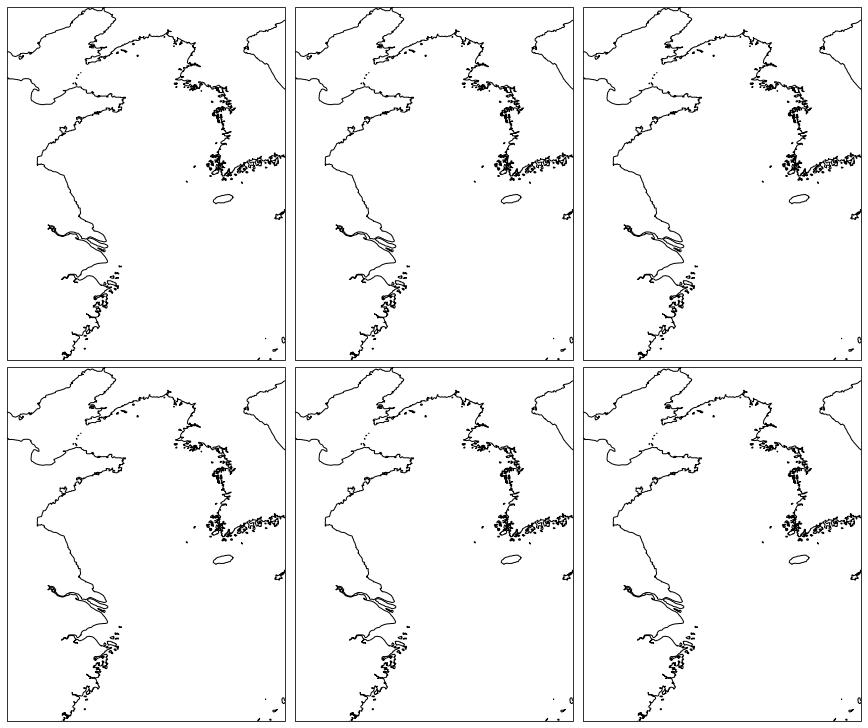

In [347]:
def calc_frontogenesis(ds, t=0, level=0):
    ds = ds.isel(Time=t)
    dx, dy = mpcalc.lat_lon_grid_deltas(ds.lon * units("degrees_E"), 
                                        ds.lat * units("degrees_N"))
    nlev = len(tds.level.values)
    dx, dy = [np.tile(dx, (nlev,1,1)), np.tile(dy, (nlev,1,1))]

    sh = mpcalc.specific_humidity_from_dewpoint(pressure=ds.p * units.hPa, 
                                                dewpoint=ds.td * units.degC)
    mfc_adv = mpcalc.advection(scalar=sh, 
                               u=ds.ua * units['m/s'], 
                               v=ds.va * units['m/s'], 
                               dx=dx, dy=dy)
    mfc_conv = -sh* mpcalc.divergence(u=ds.ua * units['m/s'], 
                                      v=ds.va * units['m/s'], 
                                      dx=dx, dy=dy)
    mfc = mfc_adv + mfc_conv
    vimfc = mfc.isel(level=slice(5,11)).sum(axis=0)*50/9.8
    viqu = (sh*ds.ua).isel(level=slice(5,11)).sum(axis=0)*50/9.8
    viqv = (sh*ds.va).isel(level=slice(5,11)).sum(axis=0)*50/9.8
    fr = mpcalc.frontogenesis(ds.th * units.kelvin, 
                              ds.ua * units['m/s'], 
                              ds.va * units['m/s'], 
                              dx=dx, dy=dy).isel(level=level)*1e9
    
    return([fr, vimfc, viqu, viqv, ds.lat, ds.lon])

proj = ccrs.PlateCarree()
nrows, ncols = [2, 3]
fig, axes = plt.subplots(nrows, ncols, figsize=(12,10), constrained_layout=True, 
                        subplot_kw=dict(projection=proj))

for ax in axes.flatten():
    ax.coastlines()
    ax.set_extent([118, 129, 27, 41], crs=proj)
    #ax.set_extent([lonW, lonE, latS, latN], crs=proj)

Tlevel = np.arange(-2,2.4,0.4)*5
Blevel = np.arange(-2,2.4,0.4)*2

#titles = ['','','']
for col, t in enumerate([48, 54, 60]):
    ax = axes[0,col]
    ax.set_title(ds3.isel(Time=t).dt, loc='center')
    fr3, vimfc3, viqu3, viqv3, lat, lon = calc_frontogenesis(ds=ds3, t=t, level=1)
    fr2, vimfc2, viqu2, viqv2, lat, lon = calc_frontogenesis(ds=ds2, t=t, level=1)
    
    cs = ax.contourf(lon, lat, fr3, levels=Tlevel, cmap=gvcmaps.BlueWhiteOrangeRed, extend='both')  
    
    skip = slice(None,None,2)
    x = np.array(ds3.longitude.isel(lon=skip, lat=skip).values).flatten()
    y = np.array(ds3.latitude.isel(lon=skip, lat=skip).values).flatten()
    z = np.array(vimfc3.isel(lon=skip, lat=skip).values).flatten()
    mask = np.where(z>1e-5)
    #ax.scatter(x[mask], y[mask], marker='.', color='k', s=10, alpha=1)
    cl = ax.contourf(lon, lat, vimfc3.where(vimfc3.values>1e-6), levels=[1e-5,100], colors=['grey'], alpha=0.5)
    #hskip=slice(None,None,4)
    #Q = ax.quiver(lon[hskip], lat[hskip], viqu3[hskip,hskip], viqv3[hskip,hskip],
    #                  color='black', pivot="middle", width=0.003, scale=100)
    
    ax = axes[1,col]
    cs = ax.contourf(lon, lat, fr3-fr2,   
                 levels=Blevel, cmap=gvcmaps.BlueWhiteOrangeRed, extend='both') 
    cl = ax.contourf(lon, lat, vimfc3-vimfc2, levels=12, alpha=0.5)
    #Q = ax.quiver(lon[hskip], lat[hskip], (viqu3-viqu2)[hskip,hskip], (viqv3-viqv2)[hskip,hskip],
    #                  color='black', pivot="middle", width=0.003, scale=25)
    fig.colorbar(cs,ax=ax)

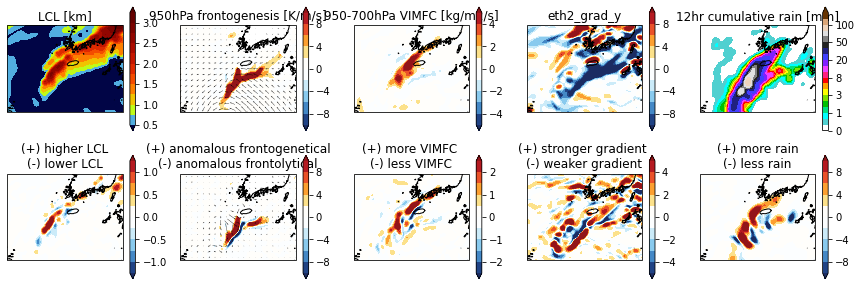

In [225]:
from matplotlib import ticker, cm

t = 60
tds1 = ds1.isel(Time=t)
tds2 = ds2.isel(Time=t)
tds3 = ds3.isel(Time=t)

proj = ccrs.PlateCarree()
nrows, ncols = [2, 5]
fig, axes = plt.subplots(nrows, ncols, figsize=(15,5), constrained_layout=True, 
                        subplot_kw=dict(projection=proj))

tds = tds3

# sst, t2, td2, eth2, 
# 1000 hPa frontogenesis
# 950-700 hPa vimfc and vectors of iuq and ivq
# precipitation 
# lcl (https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/2021GL093316)
#  - higher LCLs result in wider, deeper, and stronger cloudy updrafts 
#  - positive relationship between LCL height and deep convective updraft width 

for ax in axes.flatten():
    ax.coastlines()
    ax.set_extent([lonW, lonE, latS, latN], crs=proj)


for j in range(ncols):

    if j==0:

        #---------------------------------------
        # lifted condensation level (LCL) in km
        #---------------------------------------

        tmp2 = tds2.cape_2d.isel(mcape_mcin_lcl_lfc=2)/1000
        tmp3 = tds3.cape_2d.isel(mcape_mcin_lcl_lfc=2)/1000

        ax = axes[0,j]
        ax.set_title('LCL [km]', loc='center')
        cs = ax.contourf(tds.lon, tds.lat, mpcalc.smooth_n_point(tmp3, 9), levels=12, cmap=gvcmaps.hotres, extend='both')    
        fig.colorbar(cs, ax=ax)

        ax = axes[1,j]
        ax.set_title('(+) higher LCL\n(-) lower LCL', loc='center')
        cs = ax.contourf(tds.lon, tds.lat, mpcalc.smooth_n_point(tmp3-tmp2, 9),  
                 levels=np.arange(-5,6,1)/4, cmap=gvcmaps.BlueWhiteOrangeRed, extend='both')
        fig.colorbar(cs, ax=ax)



    elif j==1:
        #---------------------------------------
        # frontogenesis (950 hPa)
        #---------------------------------------

        dx, dy = mpcalc.lat_lon_grid_deltas(tds.lon * units("degrees_E"), tds.lat * units("degrees_N"))
        nlev = len(tds.level.values)
        dx, dy = [np.tile(dx, (nlev,1,1)), np.tile(dy, (nlev,1,1))]

        tmp2 = mpcalc.frontogenesis(tds2.th * units.kelvin, 
                                    tds2.ua * units['m/s'], 
                                    tds2.va * units['m/s'], 
                                    dx=dx, dy=dy).isel(level=0)*1e9
        
        tmp3 = mpcalc.frontogenesis(tds3.th * units.kelvin, 
                                    tds3.ua * units['m/s'], 
                                    tds3.va * units['m/s'], 
                                    dx=dx, dy=dy).isel(level=0)*1e9
        
        for tds in [tds2, tds3]:
            tds['sh'] = mpcalc.specific_humidity_from_dewpoint(pressure=tds.p * units.hPa, 
                                                               dewpoint=tds.td * units.degC)
            tds['uq'] = tds.sh * tds.ua
            tds['vq'] = tds.sh * tds.va

        ax = axes[0,j]
        ax.set_title('950hPa frontogenesis [K/m/s]', loc='center')
        cs = ax.contourf(tds.lon, tds.lat, mpcalc.smooth_n_point(tmp3, 9), 
                 levels=np.arange(-2,2.4,0.4)*5, cmap=gvcmaps.BlueWhiteOrangeRed, extend='both')    
        fig.colorbar(cs, ax=ax)
        
        hskip=slice(None,None,4)
        Q = ax.quiver(tds.lon[hskip], tds.lat[hskip], 
                      tds3.uq.isel(level=1)[hskip,hskip], 
                      tds3.vq.isel(level=1)[hskip,hskip],
                      color='black', pivot="middle", width=0.003, scale=4)

        ax = axes[1,j]
        ax.set_title('(+) anomalous frontogenetical\n(-) anomalous frontolytical', loc='center')
        cs = ax.contourf(tds.lon, tds.lat, mpcalc.smooth_n_point(tmp3-tmp2, 9),  
                 levels=np.arange(-2,2.4,0.4)*5, cmap=gvcmaps.BlueWhiteOrangeRed, extend='both')
        fig.colorbar(cs, ax=ax)
        
        Q = ax.quiver(tds.lon[hskip], tds.lat[hskip], 
                      (tds3.uq-tds2.uq).isel(level=1)[hskip,hskip], 
                      (tds3.vq-tds2.vq).isel(level=1)[hskip,hskip],
                      color='black', pivot="middle", width=0.003, scale=1)
        
    elif j==2:
        #-----------------------------------------
        # vimfc integral from 950 hPa to 500 hPa
        #-----------------------------------------

        dx, dy = mpcalc.lat_lon_grid_deltas(tds.lon * units("degrees_E"), tds.lat * units("degrees_N"))
        nlev = len(tds.level.values)
        dx, dy = [np.tile(dx, (nlev,1,1)), np.tile(dy, (nlev,1,1))]

        for tds in [tds2, tds3]:
            tds['sh'] = mpcalc.specific_humidity_from_dewpoint(pressure=tds.p * units.hPa, 
                                                               dewpoint=tds.td * units.degC)
            tds['mfc_adv'] = mpcalc.advection(scalar=tds.sh, 
                                              u=tds.ua * units['m/s'], 
                                              v=tds.va * units['m/s'], 
                                              dx=dx, dy=dy)
            tds['mfc_conv'] = -tds.sh* mpcalc.divergence(u=tds.ua * units['m/s'], 
                                                         v=tds.va * units['m/s'], 
                                                         dx=dx, dy=dy)
            tds['mfc'] = tds.mfc_adv + tds.mfc_conv

        tmp2 = tds2.mfc.isel(level=slice(1,7)).sum(axis=0)*50/9.8*1e5 # kg m-2 s-1
        tmp3 = tds3.mfc.isel(level=slice(1,7)).sum(axis=0)*50/9.8*1e5 # kg m-2 s-1
        
        ax = axes[0,j]
        ax.set_title('950-700hPa VIMFC [kg/m2/s]', loc='center')
        cs = ax.contourf(tds.lon, tds.lat, mpcalc.smooth_n_point(tmp3, 9), 
                 levels=np.arange(-5,6,1), cmap=gvcmaps.BlueWhiteOrangeRed, extend='both')    
        fig.colorbar(cs, ax=ax)

        ax = axes[1,j]
        ax.set_title('(+) more VIMFC \n(-) less VIMFC', loc='center')
        cs = ax.contourf(tds.lon, tds.lat, mpcalc.smooth_n_point(tmp3-tmp2, 9),  
                 levels=np.arange(-5,6,1)/2, cmap=gvcmaps.BlueWhiteOrangeRed, extend='both')
        fig.colorbar(cs, ax=ax)

    elif j==3:
        dx, dy = mpcalc.lat_lon_grid_deltas(tds.lon * units("degrees_E"), tds.lat * units("degrees_N"))
        for tds in [tds2, tds3]:
            tds['th2'] = mpcalc.potential_temperature(tds.slp * units.hPa, 
                                                    tds.T2 * units.kelvin)
            tds['eth2'] = mpcalc.equivalent_potential_temperature(tds.slp * units.hPa, 
                                                    tds.T2 * units.kelvin, 
                                                    tds.td2 * units.degC)
            #tds['eth2_adv'] = mpcalc.advection(scalar=tds.eth2, 
            #                                  u=tds.U10 * units['m/s'], 
            #                                  v=tds.V10 * units['m/s'], 
            #                                  dx=dx, dy=dy)*3600
            tmp = mpcalc.first_derivative(tds.eth2 * units.kelvin, axis=0, delta=dy)*1e5
            tds['eth2_grad_y'] = xr.DataArray(tmp, coords=tds.eth2.coords, dims=tds.eth2.dims)
        
        tmp2 = tds2.eth2_grad_y
        tmp3 = tds3.eth2_grad_y
        
        ax = axes[0,j]
        ax.set_title('eth2_grad_y', loc='center')
        cs = ax.contourf(tds.lon, tds.lat, mpcalc.smooth_n_point(tmp3, 9),  
                 levels=np.arange(-1,1.2,0.2)*10, cmap=gvcmaps.BlueWhiteOrangeRed, extend='both')            
        fig.colorbar(cs, ax=ax)
        
        ax = axes[1,j]
        ax.set_title('(+) stronger gradient \n(-) weaker gradient', loc='center')
        cs = ax.contourf(tds.lon, tds.lat, mpcalc.smooth_n_point(tmp3-tmp2, 9),  
                 levels=np.arange(-1,1.2,0.2)*5, cmap=gvcmaps.BlueWhiteOrangeRed, extend='both')
        fig.colorbar(cs, ax=ax)
        
    elif j==4:
        ax = axes[0,j]
        ax.set_title('12hr cumulative rain [mm]', loc='center')
        cs = ax.contourf(tds.lon, tds.lat, mpcalc.smooth_n_point(tds3.accrain_12h, 9),  
                         clevs, cmap=cmap, norm=norm, extend='max')
        fig.colorbar(cs, ax=ax)
        
        ax = axes[1,j]
        ax.set_title('(+) more rain\n(-) less rain', loc='center')
        cs = ax.contourf(tds.lon, tds.lat, mpcalc.smooth_n_point(tds3.accrain_12h-tds2.accrain_12h, 9),  
                         levels=np.arange(-1,1.2,0.2)*10, cmap=gvcmaps.BlueWhiteOrangeRed, extend='both')
        fig.colorbar(cs, ax=ax)

#ax.set_title('CPL_down', loc='right')
#ax.set_title('CPL_down - CPL_nodown', loc='right')

<xarray.DataArray 'level' (level: 6)>
array([950, 900, 850, 800, 750, 700])
Coordinates:
    Time       datetime64[ns] 2019-09-08T12:00:00
    metpy_crs  object Projection: latitude_longitude
  * level      (level) int64 950 900 850 800 750 700


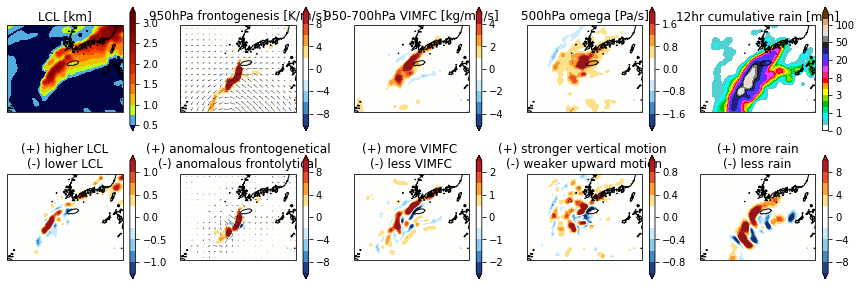

In [152]:
from matplotlib import ticker, cm

t = 60
tds1 = ds1.isel(Time=t)
tds2 = ds2.isel(Time=t)
tds3 = ds3.isel(Time=t)

proj = ccrs.PlateCarree()
nrows, ncols = [2, 5]
fig, axes = plt.subplots(nrows, ncols, figsize=(15,5), constrained_layout=True, 
                        subplot_kw=dict(projection=proj))

tds = tds3
dx, dy = mpcalc.lat_lon_grid_deltas(tds.lon * units("degrees_E"), tds.lat * units("degrees_N"))
nlev = len(tds.level.values)
dx, dy = [np.tile(dx, (nlev,1,1)), np.tile(dy, (nlev,1,1))]

# sst, t2, td2, eth2, 
# 1000 hPa frontogenesis
# 950-700 hPa vimfc and vectors of iuq and ivq
# precipitation 
# lcl (https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/2021GL093316)
#  - higher LCLs result in wider, deeper, and stronger cloudy updrafts 
#  - positive relationship between LCL height and deep convective updraft width 

for ax in axes.flatten():
    ax.coastlines()
    ax.set_extent([lonW, lonE, latS, latN], crs=proj)


for j in range(ncols):

    if j==0:

        #---------------------------------------
        # lifted condensation level (LCL) in km
        #---------------------------------------

        tmp2 = tds2.cape_2d.isel(mcape_mcin_lcl_lfc=2)/1000
        tmp3 = tds3.cape_2d.isel(mcape_mcin_lcl_lfc=2)/1000

        ax = axes[0,j]
        ax.set_title('LCL [km]', loc='center')
        cs = ax.contourf(tds.lon, tds.lat, mpcalc.smooth_n_point(tmp3, 9), levels=12, cmap=gvcmaps.hotres, extend='both')    
        fig.colorbar(cs, ax=ax)

        ax = axes[1,j]
        ax.set_title('(+) higher LCL\n(-) lower LCL', loc='center')
        cs = ax.contourf(tds.lon, tds.lat, mpcalc.smooth_n_point(tmp3-tmp2, 9),  
                 levels=np.arange(-5,6,1)/4, cmap=gvcmaps.BlueWhiteOrangeRed, extend='both')
        fig.colorbar(cs, ax=ax)



    elif j==1:
        #---------------------------------------
        # frontogenesis (950 hPa)
        #---------------------------------------

        tmp2 = mpcalc.frontogenesis(tds2.th * units.kelvin, 
                                    tds2.ua * units['m/s'], 
                                    tds2.va * units['m/s'], 
                                    dx=dx, dy=dy).isel(level=1)*1e9
        
        tmp3 = mpcalc.frontogenesis(tds3.th * units.kelvin, 
                                    tds3.ua * units['m/s'], 
                                    tds3.va * units['m/s'], 
                                    dx=dx, dy=dy).isel(level=1)*1e9
        
        for tds in [tds2, tds3]:
            tds['sh'] = mpcalc.specific_humidity_from_dewpoint(pressure=tds.p * units.hPa, 
                                                               dewpoint=tds.td * units.degC)
            tds['uq'] = tds.sh * tds.ua
            tds['vq'] = tds.sh * tds.va

        ax = axes[0,j]
        ax.set_title('950hPa frontogenesis [K/m/s]', loc='center')
        cs = ax.contourf(tds.lon, tds.lat, mpcalc.smooth_n_point(tmp3, 9), 
                 levels=np.arange(-2,2.4,0.4)*5, cmap=gvcmaps.BlueWhiteOrangeRed, extend='both')    
        fig.colorbar(cs, ax=ax)
        
        hskip=slice(None,None,4)
        Q = ax.quiver(tds.lon[hskip], tds.lat[hskip], 
                      tds3.uq.isel(level=1)[hskip,hskip], 
                      tds3.vq.isel(level=1)[hskip,hskip],
                      color='black', pivot="middle", width=0.003, scale=4)

        ax = axes[1,j]
        ax.set_title('(+) anomalous frontogenetical\n(-) anomalous frontolytical', loc='center')
        cs = ax.contourf(tds.lon, tds.lat, mpcalc.smooth_n_point(tmp3-tmp2, 9),  
                 levels=np.arange(-2,2.4,0.4)*5, cmap=gvcmaps.BlueWhiteOrangeRed, extend='both')
        fig.colorbar(cs, ax=ax)
        
        Q = ax.quiver(tds.lon[hskip], tds.lat[hskip], 
                      (tds3.uq-tds2.uq).isel(level=1)[hskip,hskip], 
                      (tds3.vq-tds2.vq).isel(level=1)[hskip,hskip],
                      color='black', pivot="middle", width=0.003, scale=1)
        
    elif j==2:
        #-----------------------------------------
        # vimfc integral from 950 hPa to 500 hPa
        #-----------------------------------------

        for tds in [tds2, tds3]:
            tds['sh'] = mpcalc.specific_humidity_from_dewpoint(pressure=tds.p * units.hPa, 
                                                               dewpoint=tds.td * units.degC)
            tds['mfc_adv'] = mpcalc.advection(scalar=tds.sh, 
                                              u=tds.ua * units['m/s'], 
                                              v=tds.va * units['m/s'], 
                                              dx=dx, dy=dy)
            tds['mfc_conv'] = -tds.sh* mpcalc.divergence(u=tds.ua * units['m/s'], 
                                                         v=tds.va * units['m/s'], 
                                                         dx=dx, dy=dy)
            tds['mfc'] = tds.mfc_adv + tds.mfc_conv

        tmp2 = tds2.mfc.isel(level=slice(1,7)).sum(axis=0)*50/9.8*1e5 # kg m-2 s-1
        tmp3 = tds3.mfc.isel(level=slice(1,7)).sum(axis=0)*50/9.8*1e5 # kg m-2 s-1
        
        ax = axes[0,j]
        ax.set_title('950-700hPa VIMFC [kg/m2/s]', loc='center')
        cs = ax.contourf(tds.lon, tds.lat, mpcalc.smooth_n_point(tmp3, 9), 
                 levels=np.arange(-5,6,1), cmap=gvcmaps.BlueWhiteOrangeRed, extend='both')    
        fig.colorbar(cs, ax=ax)

        ax = axes[1,j]
        ax.set_title('(+) more VIMFC \n(-) less VIMFC', loc='center')
        cs = ax.contourf(tds.lon, tds.lat, mpcalc.smooth_n_point(tmp3-tmp2, 9),  
                 levels=np.arange(-5,6,1)/2, cmap=gvcmaps.BlueWhiteOrangeRed, extend='both')
        fig.colorbar(cs, ax=ax)

    elif j==3:
        ax = axes[0,j]
        ax.set_title('500hPa omega [Pa/s]', loc='center')
        cs = ax.contourf(tds.lon, tds.lat, mpcalc.smooth_n_point(-tds3.isel(level=10).omg, 9),  
                 levels=np.arange(-1,1.2,0.2)*2, cmap=gvcmaps.BlueWhiteOrangeRed, extend='both')            
        fig.colorbar(cs, ax=ax)
        
        ax = axes[1,j]
        ax.set_title('(+) stronger vertical motion \n(-) weaker upward motion', loc='center')
        cs = ax.contourf(tds.lon, tds.lat, mpcalc.smooth_n_point(-(tds3.isel(level=10).omg-tds2.isel(level=10).omg), 9),  
                 levels=np.arange(-1,1.2,0.2), cmap=gvcmaps.BlueWhiteOrangeRed, extend='both')
        fig.colorbar(cs, ax=ax)
        
    elif j==4:
        ax = axes[0,j]
        ax.set_title('12hr cumulative rain [mm]', loc='center')
        cs = ax.contourf(tds.lon, tds.lat, mpcalc.smooth_n_point(tds3.accrain_12h, 9),  
                         clevs, cmap=cmap, norm=norm, extend='max')
        fig.colorbar(cs, ax=ax)
        
        ax = axes[1,j]
        ax.set_title('(+) more rain\n(-) less rain', loc='center')
        cs = ax.contourf(tds.lon, tds.lat, mpcalc.smooth_n_point(tds3.accrain_12h-tds2.accrain_12h, 9),  
                         levels=np.arange(-1,1.2,0.2)*10, cmap=gvcmaps.BlueWhiteOrangeRed, extend='both')
        fig.colorbar(cs, ax=ax)

#ax.set_title('CPL_down', loc='right')
#ax.set_title('CPL_down - CPL_nodown', loc='right')

#### low-level moisture intrusion (w. diabatic heating via low cloud)
- Frontogenesis is most common generated when given a strengthening baroclinic zone in the presence of sufficient moisture for precipitation.
- The concentrated moisture flux and its convergence field represented forcing for strong ascent over the frontal zone, which matched up very well with postivie frontogenesis field.

#### degree of frontal slope (w. vertical moiton)
- The degree of the sloped frontogenetical zone is important; a steeper slope implies a greater rise in warm and moist air.
- The ascent aloft can also occur above the area of low-level maximum frontogenesis and even moisture convergence field. 
- Thus, the steeper the slope, the better the potential for heavy precipitation.

기타:
   - (Keyser et al., 1988; Schultz and Doswell, 1999)
   - Higher precipitable water values mean that more water is available for potential rainfall.
   - Relative humidity is almost inversely proportional to the amount of the air temperature minus dew point. 
   - Low-level frontogenesis due to diabatic heating can be important in unstable environments, where the resulting small-scale frontal lift causes convective development.
   - The presence of significant frontogenetical forcing and moisture could lead to an area of heavy precipitation.
   - (vorticity) If a sheared wind field (containing vorticity) is applied to an initially uniform thermal gradient, the wind field will act to rotate the thermal gradient at a later time.

i) A weak trough was located over New Mexico and eastern Colorado, with confluent flow over eastern Kansas.

ii) Sfc map 00 utc 15 Oct: A weak low was over Colorado, with warm air to the south and cooler air to the northeast.

iii) Sfc map 12 utc 15 Oct: A weak low moved or reformed over OK, with a weak front extending through eastern KS and MO.

iv) 925 mb 12 utc 15 Oct: Above the surface, note that the wind fields suggested a tightening thermal gradient across eastern Kansas and western Missouri where convergence was resulting in a stretching deformation field.

* The use of a spatialheight cross-section, allows excellent visualization of sloping frontogenetical zones.



연직(하층, 중층, 상층) 구름 분포로 공기의 응결(증발)에 의한 diabatic heating (cooling)을 판단하고, 그 분포를 theta-e와 비교하자.

해양을 결합했을 때 강수량이 줄어듦. 이는 SST 변화에 따른 응결이 줄어들었기 때문?

Reduced the dew point temperature of the air via air-sea coupling leads to prevent condensation at the low-level atmosphere.

The lower tropospheric weak diabatic heating is related to the cooler

astd-> decrease in dew point, precipitable water, low cloud fraction, precipitation rate

차이가 너무 크니까 해양 결합에 따른 구름 모수화 스킴의 튜닝이 필요할지도..?

모의 기간 내내 한반도 서쪽 황해 상층(300hPa)에 기압골이 머무름. 기압골 주변의 강한 상층 발산은 주변 기류의 상승과 하층의 저기압성 흐름을 유도하고 결과적으로 기상 악화(강수량 변화)를 초래할 수 있음.

대류권 하층에서의 수분 유입

## The 12hr accumulated preciptation over the analysis domain

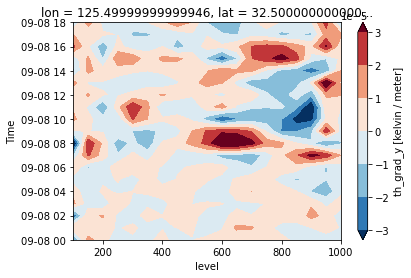

In [228]:
rh2=ds2.th_grad_y.isel(Time=slice(48,None), lon=95, lat=55)
rh3=ds3.th_grad_y.isel(Time=slice(48,None), lon=95, lat=55)
(rh3-rh2).plot.contourf(robust=True)

(19, 151, 201)


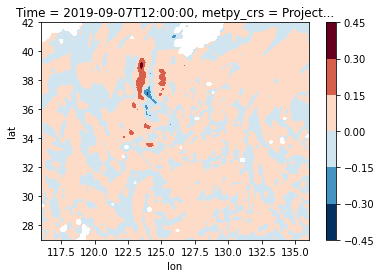

In [258]:
tke2=mpcalc.tke(ds2.ua.values, 
               ds2.va.values, 
               ds2.wa.values, 
               perturbation=True, axis=0)
tke3=mpcalc.tke(ds3.ua.values, 
               ds3.va.values, 
               ds3.wa.values, 
               perturbation=True, axis=0)
tke=tke3-tke2
tke=xr.DataArray(tke, coords=ds2.ua.isel(Time=36).coords)
print(np.shape(tke))
tke.isel(level=2).plot.contourf()

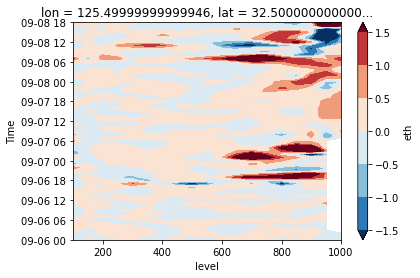

In [280]:
fr2=ds2.eth.isel(lon=95, lat=55)
fr3=ds3.eth.isel(lon=95, lat=55)
#ds3.landmask.plot.contour()
(fr3-fr2).plot.contourf(robust=True)

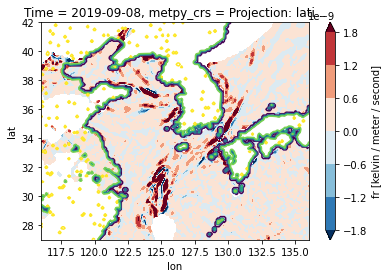

In [273]:
fr2=ds2.fr.isel(Time=48, level=0)
fr3=ds3.fr.isel(Time=48, level=0)
ds3.landmask.plot.contour()
(fr3-fr2).plot.contourf(robust=True)

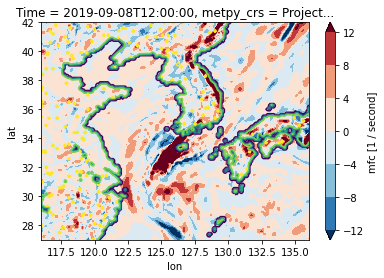

In [265]:
#  uq   = u*q                                  ; (:,:,:,:)
#  uq@long_name = "Zonal Moisture Flux [uq]"
#  uq_dpg = uq*dpg                ; mass weighted 'uq'; [m/s][g/kg][kg/m2]=>[m/s][g/kg]
#  iuq    = dim_sum_n(uq_dpg, 1)

mfc2=ds2.mfc.isel(Time=60, level=slice(1,7)).sum(axis=0)*50/9.8*1e6 # kg m-2 s-1
mfc3=ds3.mfc.isel(Time=60, level=slice(1,7)).sum(axis=0)*50/9.8*1e6 # kg m-2 s-1
ds3.landmask.plot.contour()
mfc3.plot.contourf(robust=True)

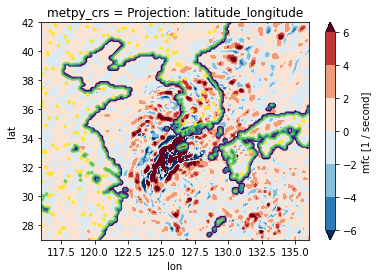

In [266]:
(mfc3-mfc2).plot.contourf(robust=True)
ds3.landmask.plot.contour()

IndexError: index 1941 is out of bounds for axis 0 with size 1938

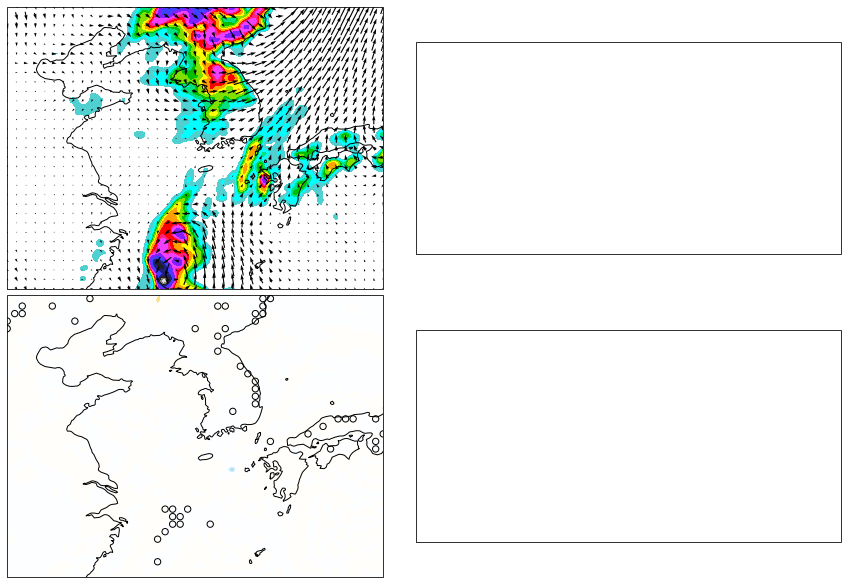

In [24]:
# draw filled contours.
clevs = [0, 1, 2.5, 5, 7.5, 10, 15, 20, 30, 40,
         50, 70, 100, 150, 200, 250, 300, 400, 500, 600, 750]
clevs = [ c/5 for c in clevs]
# In future MetPy
# norm, cmap = ctables.registry.get_with_boundaries('precipitation', clevs)
cmap_data = [(1.0, 1.0, 1.0),
             (0.3137255012989044, 0.8156862854957581, 0.8156862854957581),
             (0.0, 1.0, 1.0),
             (0.0, 0.8784313797950745, 0.501960813999176),
             (0.0, 0.7529411911964417, 0.0),
             (0.501960813999176, 0.8784313797950745, 0.0),
             (1.0, 1.0, 0.0),
             (1.0, 0.6274510025978088, 0.0),
             (1.0, 0.0, 0.0),
             (1.0, 0.125490203499794, 0.501960813999176),
             (0.9411764740943909, 0.250980406999588, 1.0),
             (0.501960813999176, 0.125490203499794, 1.0),
             (0.250980406999588, 0.250980406999588, 1.0),
             (0.125490203499794, 0.125490203499794, 0.501960813999176),
             (0.125490203499794, 0.125490203499794, 0.125490203499794),
             (0.501960813999176, 0.501960813999176, 0.501960813999176),
             (0.8784313797950745, 0.8784313797950745, 0.8784313797950745),
             (0.9333333373069763, 0.8313725590705872, 0.7372549176216125),
             (0.8549019694328308, 0.6509804129600525, 0.47058823704719543),
             (0.6274510025978088, 0.42352941632270813, 0.23529411852359772),
             (0.4000000059604645, 0.20000000298023224, 0.0)]
cmap = mcolors.ListedColormap(cmap_data, 'precipitation')
norm = mcolors.BoundaryNorm(clevs, cmap.N)

proj = ccrs.PlateCarree()
fig, axes = plt.subplots(2,2, figsize=(12,8), constrained_layout=True, subplot_kw=dict(projection=proj))
for i, t in enumerate([48, 60]):
    ax = axes[0,i]
    ax.coastlines()
    cs1 = ax.contourf(ds3.lon, ds3.lat, ds3.isel(Time=t).accrain_12h, clevs, cmap=cmap, norm=norm)
    
    hskip=slice(None,None,5)
    qu = ds3.isel(Time=t, level=3).ua * ds3.isel(Time=t, level=3).sh
    qv = ds3.isel(Time=t, level=3).va * ds3.isel(Time=t, level=3).sh
    Q = ax.quiver(ds3.lon[hskip], ds3.lat[hskip], qu[hskip,hskip], qv[hskip,hskip],
                      color='black', pivot="middle", width=0.003, scale=5)

    ax = axes[1,i]
    ax.coastlines()
    cs2 = ax.contourf(ds3.lon, ds3.lat, ds3.isel(Time=t).accrain_12h-ds2.isel(Time=t).accrain_12h, 
                    levels=np.arange(-20,24,4), cmap=gvcmaps.BlueWhiteOrangeRed, extend='both')
    
    skip = slice(None,None,4)
    x = np.array(ds3.longitude.isel(lon=skip, lat=skip).values).flatten()
    y = np.array(ds3.latitude.isel(lon=skip, lat=skip).values).flatten()
    z = np.array(ds3.isel(Time=t, level=3, lon=skip, lat=skip).mfc.values).flatten()
    mask = np.where(z>1e-6)
    ax.scatter(x[mask], y[mask], marker='o', color='none', s=40, edgecolor='k')
    
    skip = slice(None,None,1)
    z = np.array(ds3.isel(Time=t, level=0, lon=skip, lat=skip).fr.values).flatten()
    mask = np.where(z>0)
    ax.scatter(x[mask], y[mask], marker='o', color='k', s=40)
            
    #cl2 = ax.contour(ds3.lon, ds3.lat, ds3.isel(Time=t, level=3).mfc-ds2.isel(Time=t, level=3).mfc, 
    #                levels=12, colors='k')

cbar = plt.colorbar(cs1, ax=axes[0,:], orientation='vertical')
cbar = plt.colorbar(cs2, ax=axes[1,:], orientation='vertical')
#cbar.set_label(data.units)

<xarray.DataArray 'level' (level: 19)>
array([1000,  950,  900,  850,  800,  750,  700,  650,  600,  550,  500,  450,
        400,  350,  300,  250,  200,  150,  100])
Coordinates:
    metpy_crs  object Projection: latitude_longitude
  * level      (level) int64 1000 950 900 850 800 750 ... 300 250 200 150 100


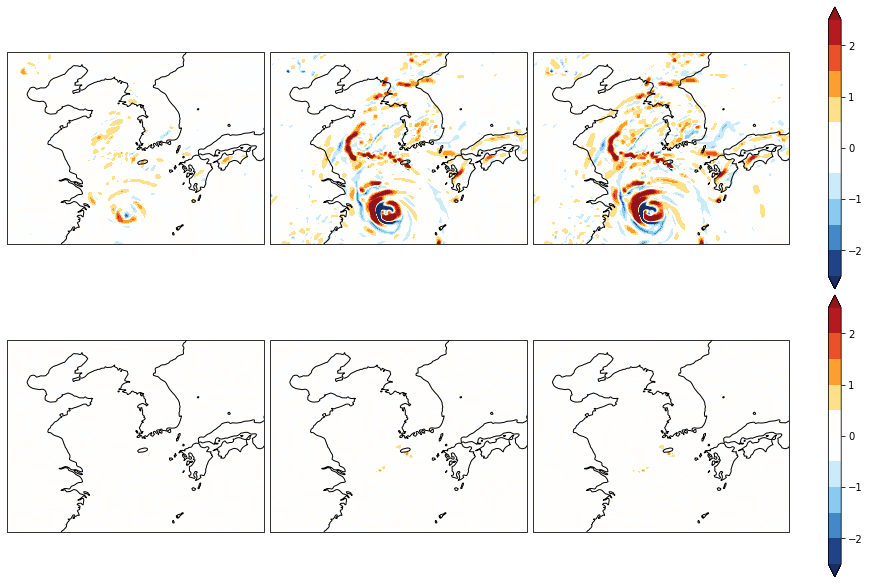

In [54]:
proj = ccrs.PlateCarree()
fig, axes = plt.subplots(2, 3, figsize=(12,8), constrained_layout=True, subplot_kw=dict(projection=proj))

print(ds3.level)
t=6
l=5
for i, v in enumerate(['mfc_adv', 'mfc_conv', 'mfc']):
    for j, ax in enumerate(axes[:,i].flatten()):
        ax.coastlines()
        
        if j==0:
            csT = ax.contourf(ds3.lon, ds3.lat, ds3[v].isel(Time=t, level=l)*1e6,
                             levels=np.arange(-1,1.2,0.2)*2.5, cmap=gvcmaps.BlueWhiteOrangeRed, extend='both')
        else:
            csB = ax.contourf(ds3.lon, ds3.lat, (ds3[v].isel(Time=t, level=l)-ds2[v].isel(Time=t, level=l))*1e6,
                             levels=np.arange(-1,1.2,0.2)*2.5, cmap=gvcmaps.BlueWhiteOrangeRed, extend='both')
cbar = plt.colorbar(csT, ax=axes[0,:], orientation='vertical')
cbar = plt.colorbar(csB, ax=axes[1,:], orientation='vertical')

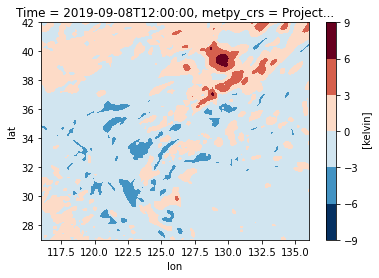

In [61]:
t=60
l=5
th_es1 = mpcalc.saturation_equivalent_potential_temperature(ds1.p.isel(Time=t)*units.hPa,
                                                          ds1.tc.isel(Time=t)*units.degC)
th_es3 = mpcalc.saturation_equivalent_potential_temperature(ds3.p.isel(Time=t)*units.hPa,
                                                          ds3.tc.isel(Time=t)*units.degC)
(th_es3.isel(level=l)-th_es1.isel(level=l)).plot.contourf()

<xarray.DataArray 'Time' ()>
array('2019-09-07T15:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    Time       datetime64[ns] 2019-09-07T15:00:00
    metpy_crs  object Projection: latitude_longitude
Attributes:
    _metpy_axis:  time


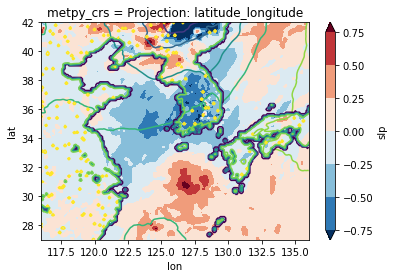

In [187]:
x = ds1.slp.isel(Time=39)
y = ds3.slp.isel(Time=39)
print(y.Time)
(y-x).plot.contourf(robust=True)
y.plot.contour()
ds3.landmask.plot.contour()

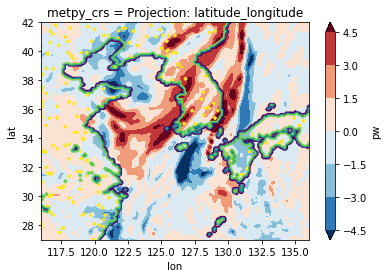

In [185]:
x = ds1.pw.isel(Time=39)
y = ds3.pw.isel(Time=39)
(y-x).plot.contourf(robust=True)
ds3.landmask.plot.contour()

<xarray.DataArray 'Time' ()>
array('2019-09-07T15:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    Time       datetime64[ns] 2019-09-07T15:00:00
    metpy_crs  object Projection: latitude_longitude
Attributes:
    _metpy_axis:  time


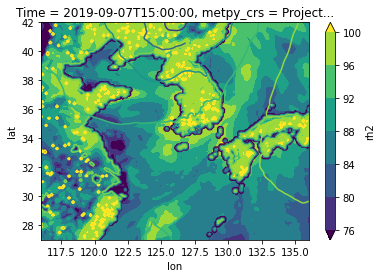

In [196]:
x = (ds1.rh2).isel(Time=39)
y = (ds3.rh2).isel(Time=39)
print(y.Time)
(y).plot.contourf(robust=True)
ds3.landmask.plot.contour()
ds3.z.isel(Time=39,level=3).plot.contour()

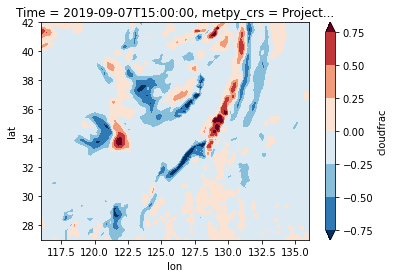

In [184]:
x = ds1.cloudfrac.isel(low_mid_high=1, Time=39)
y = ds3.cloudfrac.isel(low_mid_high=1, Time=39)
(y-x).plot.contourf(robust=True)

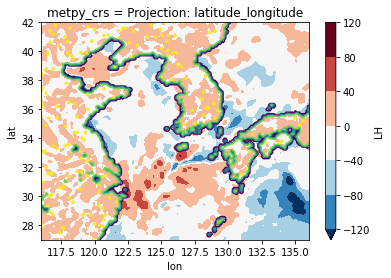

In [158]:
x = ds1.LH.isel(Time=60)
y = ds3.LH.isel(Time=60)
(y-x).plot.contourf(robust=True)
ds3.landmask.plot.contour()

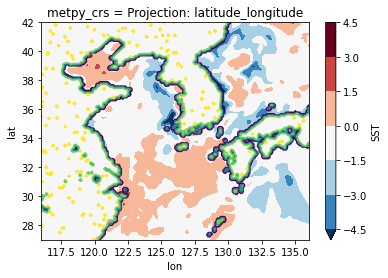

In [159]:
x = ds1.SST.isel(Time=60)
y = ds3.SST.isel(Time=60)
(y-x).plot.contourf(robust=True)
ds3.landmask.plot.contour()

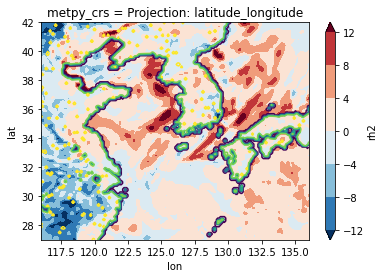

In [166]:
x = ds1.rh2.isel(Time=60)
y = ds3.rh2.isel(Time=60)
(y-x).plot.contourf(robust=True)
ds3.landmask.plot.contour()

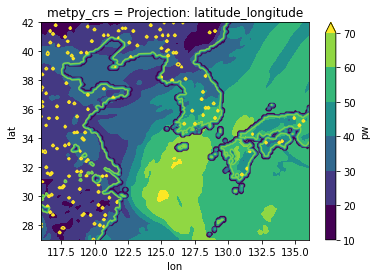

In [163]:
x = ds1.pw.isel(Time=60)
y = ds3.pw.isel(Time=60)
(y).plot.contourf(robust=True)
ds3.landmask.plot.contour()

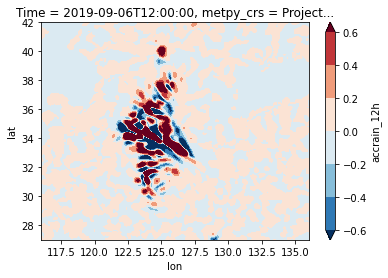

In [202]:
x = ds2.accrain_12h.isel(Time=12)
y = ds3.accrain_12h.isel(Time=12)
(y-x).plot.contourf(robust=True)

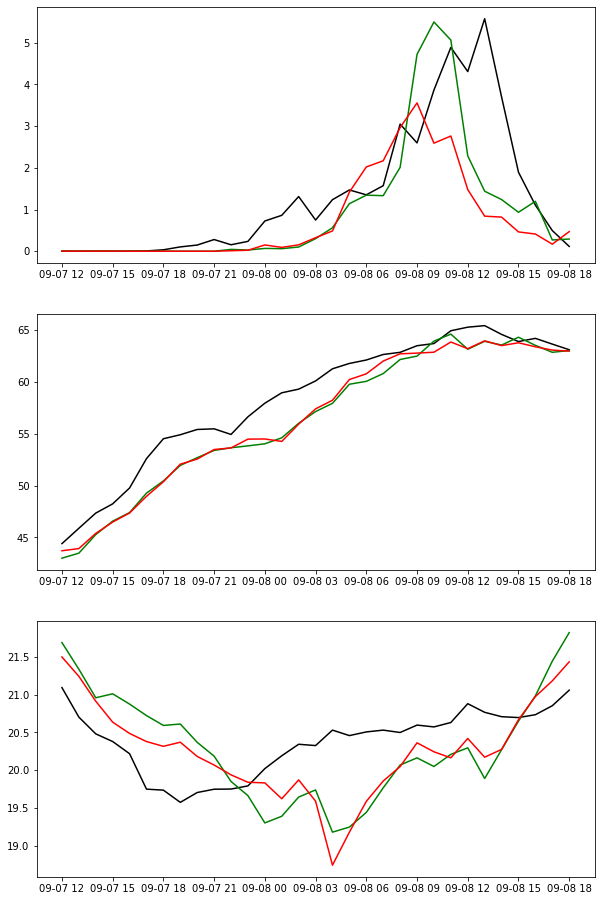

In [207]:
weights = np.cos(np.deg2rad(ds1.lat))
weights.name = "weights"
weights

#lonW, lonE, latS, latN = [118, 128, 27, 42] # analysis domain
# 33.2462	126.5653	

lonW, lonE, latS, latN = [126.5, 126.7, 33.2, 33.4]
time_slice = slice(36,67,1) #slice(39,67,1)

fig, axes = plt.subplots(3,1, figsize=(10,16))

for i, (ax, var) in enumerate(zip(axes.flatten(), ['rain', 'pw', 'td2'])):
    for ds, c in zip([ds1, ds2, ds3], ['k','g','r']):
        rain = ds[var].sel(lon=slice(lonW,lonE), lat=slice(latS,latN)).isel(Time=time_slice).mean(("lon", "lat"))
        ax.plot(rain.Time, rain, color=c, label='NOCPL')
#rain2 = ds2.rain.sel(lon=slice(lonW,lonE), lat=slice(latS,latN)).isel(Time=time_slice).mean(("lon", "lat"))
#rain3 = ds3.rain.sel(lon=slice(lonW,lonE), lat=slice(latS,latN)).isel(Time=time_slice).mean(("lon", "lat"))

#td1 = (ds1.T2-273.15-ds1.td2).sel(lon=slice(lonW,lonE), lat=slice(latS,latN)).isel(Time=slice(39,67,1)).weighted(weights).mean(("lon", "lat"))
#td2 = (ds2.T2-273.15-ds2.td2).sel(lon=slice(lonW,lonE), lat=slice(latS,latN)).isel(Time=slice(39,67,1)).weighted(weights).mean(("lon", "lat"))
#td3 = (ds3.T2-273.15-ds3.td2).sel(lon=slice(lonW,lonE), lat=slice(latS,latN)).isel(Time=slice(39,67,1)).weighted(weights).mean(("lon", "lat"))

#rh1 = ds1.rh2.sel(lon=slice(lonW,lonE), lat=slice(latS,latN)).isel(Time=slice(39,67,1)).weighted(weights).mean(("lon", "lat"))
#rh2 = ds2.rh2.sel(lon=slice(lonW,lonE), lat=slice(latS,latN)).isel(Time=slice(39,67,1)).weighted(weights).mean(("lon", "lat"))
#rh3 = ds3.rh2.sel(lon=slice(lonW,lonE), lat=slice(latS,latN)).isel(Time=slice(39,67,1)).weighted(weights).mean(("lon", "lat"))



#ax = axes[0]

#ax.plot(rain1.Time, rain2, color='gold', label='NOCPL')
#ax.plot(rain1.Time, rain3, color='r', label='NOCPL')

#ax.bar([r-0.2 for r in range(len(rain1.Time))], rain1.values, width=0.2, color='grey', label='NOCPL')
#ax.bar([r for r in range(len(rain1.Time))], rain2.values, width=0.2, color='gold', label='NOCPL')
#ax.bar([r+0.2 for r in range(len(rain1.Time))], rain3.values, width=0.2, color='r', label='NOCPL')
#ax.plot(rain1.Time, rain1s, lw=2, color='g', label='NOCPLs')
#ax.plot(rain1.Time, rain2, lw=2, color='dodgerblue', label='CPL_nodown')
#ax.plot(rain1.Time, rain3, lw=2, color='red', label='CPL_down')
#ax.legend()

#ax = axes[1]
#ax.plot(rain1.Time, td1, lw=2, color='k', label='NOCPL')
#ax.plot(rain1.Time, td2, lw=2, color='dodgerblue', label='CPL_nodown')
#ax.plot(rain1.Time, td3, lw=2, color='red', label='CPL_down')
#ax.legend()

#ax = axes[2]
#ax.plot(rain1.Time, rh1, lw=2, color='k', label='NOCPL')
#ax.plot(rain1.Time, rh2, lw=2, color='dodgerblue', label='CPL_nodown')
#ax.plot(rain1.Time, rh3, lw=2, color='red', label='CPL_down')
#ax.legend()

NameError: name 'mask' is not defined

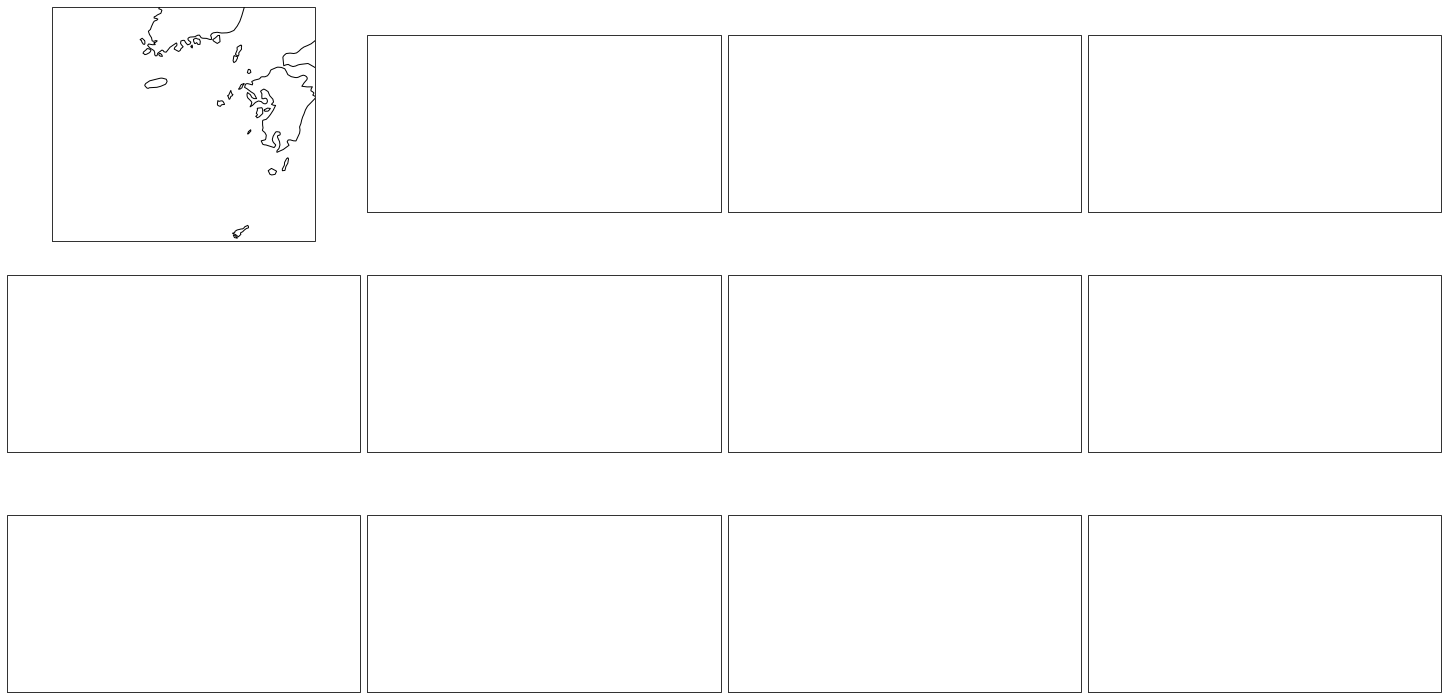

In [203]:
proj = ccrs.PlateCarree()
fig, axes = plt.subplots(3, 4, figsize=(20,10), constrained_layout=True, subplot_kw=dict(projection=proj))

for i, t in enumerate(np.arange(42,66,6)):
    for j, (ax, ts) in enumerate(zip(axes[:,i].flatten(), [ds2, ds3])):
        ax.coastlines(resolution='50m')
        #ax.set_extent([118, 132, 27, 42], crs=proj) # analysis domain

        ax.set_extent([123, 132, 28, 36], crs=proj) # analysis domain
    
        l = 3
        level = ts.level.isel(level=l).values
        title = "{}hPa MFC*1e-6, surface FR (>5e-9)".format(level)
        #cs = ax.contourf(ts.lon, ts.lat, ts.isel(Time=t, level=l).mfc*1e6, 
                             #levels=np.arange(-1,1.2,0.2)*2, 
                             #cmap=gvcmaps.BlueWhiteOrangeRed, extend='both')
        
        cs = ax.contourf(ts.lon, ts.lat, ts.isel(Time=t, level=1).eth.where(mask==0), 
                         #levels=np.arange(322,350,2), 
                         levels=12, 
                         cmap=gvcmaps.BlueWhiteOrangeRed, extend='both')
        
        dx, dy = mpcalc.lat_lon_grid_deltas(ts.lon * units("degrees_E"), 
                                            ts.lat * units("degrees_N"))
        nlev = len(ts.level.values)
        dx, dy = [np.tile(dx, (nlev,1,1)), np.tile(dy, (nlev,1,1))]
        u_g, v_g = mpcalc.geostrophic_wind(height=ts.isel(Time=t).z * units.meter, 
                                           latitude=ts.lat * units("degrees_N"), dx=dx, dy=dy)
        qg_fr = mpcalc.frontogenesis(ts.th.isel(Time=t) * units.kelvin, u_g, v_g,
                          dx=dx, dy=dy)

        hskip = slice(None, None, 5)
        qu = ts.isel(Time=t, level=l).ua * ts.isel(Time=t, level=l).sh
        qv = ts.isel(Time=t, level=l).va * ts.isel(Time=t, level=l).sh
        #qu = u_g.isel(level=l) #* ts.isel(Time=t, level=l).sh
        #qv = v_g.isel(level=l) #* ts.isel(Time=t, level=l).sh
        Q = ax.quiver(ts.lon[hskip], ts.lat[hskip], qu[hskip,hskip], qv[hskip,hskip],
                      color='black', pivot="middle", width=0.003, scale=1)
        
        cl = ax.contour(ts.lon, ts.lat, ts.isel(Time=t, level=0).fr*1e9, 
                            levels=[2], linewidths=1, colors='lime')
        
        if j==0: 
            ax.set_title(ts['Time'].isel(Time=t).dt.strftime("%HZ/%d").values, fontsize=12)
    
    ax = axes[2,i]
    ax.coastlines(resolution='50m')
    ax.set_extent([123, 132, 28, 36], crs=proj) # analysis domain
    cs = ax.contourf(ts.lon, ts.lat, (ds3.isel(Time=t, level=1).eth-ds1.isel(Time=t, level=1).eth).where(mask==0), 
                         #levels=np.arange(322,350,2), 
                         levels=12, 
                         cmap=gvcmaps.BlueWhiteOrangeRed, extend='both')
    
    #if i==0: 
    #    ax.text(-0.15, 0.5, left_title, fontsize=15, va='center', ha='center', rotation=90, transform=ax.transAxes)
    
fig.colorbar(cs, ax=axes)

### Calculate differences:
* 31 means CPL_down minus NOCPL
* 32 means CPL_down minus CPL_nodown

In [13]:
lon, lat = ds1.lon, ds1.lat

# differences in original dataset
ds31 = ds3-ds1
ds32 = ds3-ds2

### Interploate cross-section:

In [11]:
# locations of the cross-line
cross_start, cross_end = (35, 123), (31, 129)
#cross_start, cross_end = (36, 126), (28, 126)

lonW, latS, lonE, latN = [cross_start[1]-1, cross_end[0]-1, cross_end[1]+1, cross_start[0]+1]

In [12]:
cross1 = cross_section(ds1, cross_start, cross_end).set_coords(('lat','lon'))
cross1['t_wind'], cross1['n_wind'] = mpcalc.cross_section_components(cross1['ua'], cross1['va'])
    
cross2 = cross_section(ds2, cross_start, cross_end).set_coords(('lat','lon'))
cross2['t_wind'], cross2['n_wind'] = mpcalc.cross_section_components(cross2['ua'], cross2['va'])

cross3 = cross_section(ds3, cross_start, cross_end).set_coords(('lat','lon'))
cross3['t_wind'], cross3['n_wind'] = mpcalc.cross_section_components(cross3['ua'], cross3['va'])

# differences in cross-section
cross31 = cross3-cross1
cross32 = cross3-cross2

KeyError: 'u_g'

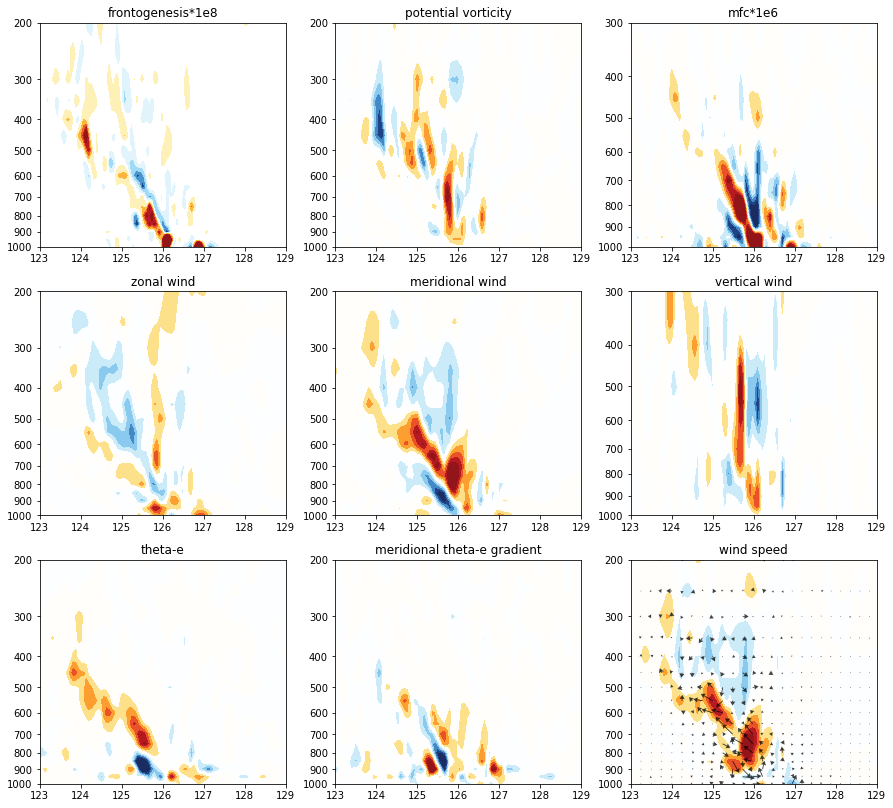

In [92]:
fig, axes = plt.subplots(3,3, figsize=(15,14))#, constrained_layout=True)

x = cross32.lon
y = cross32.level

cmap = gvcmaps.BlueWhiteOrangeRed

ax = axes[0,0]
cs = ax.contourf(x, y, cross32.isel(Time=60).fr*1e8,
                 levels=np.arange(-9,11,2)/10, cmap=cmap, extend='both')
#cbar = fig.colorbar(cs, ax=ax, orientation='horizontal')
ax.set_yscale('symlog')
ax.set_yticks(np.arange(1000,0,-100))
ax.set_yticklabels(np.arange(1000,0,-100))
ax.set_ylim([1000, 200])
ax.set_title('frontogenesis*1e8')

ax = axes[0,1]
cs = ax.contourf(x, y, cross32.isel(Time=60).pvo,
                 levels=np.arange(-10,12,2)/4, cmap=gvcmaps.BlueWhiteOrangeRed, extend='both')
#cbar = fig.colorbar(cs, ax=ax, orientation='horizontal')
ax.set_yscale('symlog')
ax.set_yticks(np.arange(1000,0,-100))
ax.set_yticklabels(np.arange(1000,0,-100))
ax.set_ylim([1000, 200])
ax.set_title('potential vorticity')

ax = axes[0,2]
cs = ax.contourf(x, y, cross32.isel(Time=60).mfc*1e6, 
                 levels=np.arange(-10,12,2)/4, cmap=gvcmaps.BlueWhiteOrangeRed, extend='both')
#cbar = fig.colorbar(cs, ax=ax, orientation='horizontal')
ax.set_yscale('symlog')
ax.set_yticks(np.arange(1000,0,-100))
ax.set_yticklabels(np.arange(1000,0,-100))
ax.set_ylim([1000, 300])
ax.set_title('mfc*1e6')

ax = axes[1,0]
cs = ax.contourf(x, y, cross32.isel(Time=60).ua,
                 levels=np.arange(-10,12,2)/2, cmap=gvcmaps.BlueWhiteOrangeRed, extend='both')
#cbar = fig.colorbar(cs, ax=ax, orientation='horizontal')
ax.set_yscale('symlog')
ax.set_yticks(np.arange(1000,0,-100))
ax.set_yticklabels(np.arange(1000,0,-100))
ax.set_ylim([1000, 200])
ax.set_title('zonal wind')

ax = axes[1,1]
cs = ax.contourf(x, y, cross32.isel(Time=60).va,
                 levels=np.arange(-10,12,2)/2, cmap=gvcmaps.BlueWhiteOrangeRed, extend='both')
#cbar = fig.colorbar(cs, ax=ax, orientation='horizontal')
ax.set_yscale('symlog')
ax.set_yticks(np.arange(1000,0,-100))
ax.set_yticklabels(np.arange(1000,0,-100))
ax.set_ylim([1000, 200])
ax.set_title('meridional wind')

ax = axes[1,2]
cs = ax.contourf(x, y, cross32.isel(Time=60).wa, 
                 levels=12, cmap=gvcmaps.BlueWhiteOrangeRed, extend='both')
#cbar = fig.colorbar(cs, ax=ax, orientation='horizontal')
ax.set_yscale('symlog')
ax.set_yticks(np.arange(1000,0,-100))
ax.set_yticklabels(np.arange(1000,0,-100))
ax.set_ylim([1000, 300])
ax.set_title('vertical wind')

ax = axes[2,0]
cs = ax.contourf(x, y, cross32.isel(Time=60).eth,
                 levels=np.arange(-10,12,2)/2, cmap=gvcmaps.BlueWhiteOrangeRed, extend='both')
#cbar = fig.colorbar(cs, ax=ax, orientation='horizontal')
ax.set_yscale('symlog')
ax.set_yticks(np.arange(1000,0,-100))
ax.set_yticklabels(np.arange(1000,0,-100))
ax.set_ylim([1000, 200])
ax.set_title('theta-e')

ax = axes[2,1]
cs = ax.contourf(x, y, cross32.isel(Time=60).eth_grad_y*1000,
                 levels=np.arange(-10,12,2)/50, cmap=gvcmaps.BlueWhiteOrangeRed, extend='both')
#cbar = fig.colorbar(cs, ax=ax, orientation='horizontal')
ax.set_yscale('symlog')
ax.set_yticks(np.arange(1000,0,-100))
ax.set_yticklabels(np.arange(1000,0,-100))
ax.set_ylim([1000, 200])
ax.set_title('meridional theta-e gradient')

ax = axes[2,2]
cs = ax.contourf(x, y, cross32.isel(Time=60).wspd, 
                 levels=np.arange(-10,12,2)/2, cmap=gvcmaps.BlueWhiteOrangeRed, extend='both')
#cbar = fig.colorbar(cs, ax=ax, orientation='horizontal')
ax.set_yscale('symlog')
ax.set_yticks(np.arange(1000,0,-100))
ax.set_yticklabels(np.arange(1000,0,-100))
ax.set_ylim([1000, 200])
ax.set_title('wind speed')

skip = slice(None,None,4)
q = ax.quiver(x[skip], y[:],
              cross32.isel(Time=60).t_wind[:,skip], 
              cross32.isel(Time=60).n_wind[:,skip],
              headwidth=6, width=0.0035, scale=100, alpha=0.75, color='k')

In [664]:
ds3

<xarray.Dataset>
Dimensions:      (Time: 67, lon: 201, lat: 151, level: 19)
Coordinates:
  * Time         (Time) datetime64[ns] 2019-09-06 ... 2019-09-08T18:00:00
    wspd_wdir    <U4 'wspd'
  * lon          (lon) float64 116.0 116.1 116.2 116.3 ... 135.8 135.9 136.0
  * lat          (lat) float64 27.0 27.1 27.2 27.3 27.4 ... 41.7 41.8 41.9 42.0
    metpy_crs    object Projection: latitude_longitude
  * level        (level) int64 1000 950 900 850 800 750 ... 300 250 200 150 100
Data variables: (12/46)
    PSFC         (Time, lat, lon) float64 9.455e+04 9.547e+04 ... 1.007e+05
    SST          (Time, lat, lon) float64 298.5 298.4 298.7 ... 294.1 294.3
    U10          (Time, lat, lon) float64 -0.1744 -0.1768 ... 3.323 3.515
    V10          (Time, lat, lon) float64 -1.162 -1.126 -0.995 ... 1.985 2.107
    HFX          (Time, lat, lon) float64 0.0 0.0 0.0 ... -2.155 -2.12 -2.122
    LH           (Time, lat, lon) float64 0.0 0.0 0.0 ... -3.624 -3.164 -2.434
    ...           ...
    mfc_conv     (Time, level, lat, lon) float64 <Quantity([[[[            na...
    mfc          (Time, level, lat, lon) float64 <Quantity([[[[            na...
    fr           (Time, level, lat, lon) float64 <Quantity([[[[            na...
    qg_fr        (Time, level, lat, lon) float64 <Quantity([[[[            na...
    lats         (lat, lon) float64 27.0 27.0 27.0 27.0 ... 42.0 42.0 42.0 42.0
    lons         (lat, lon) float64 116.0 116.1 116.2 ... 135.8 135.9 136.0
Attributes:
    regrid_method:  bilinear

## Final version

### CPL_down

AttributeError: 'Dataset' object has no attribute 'mfc'

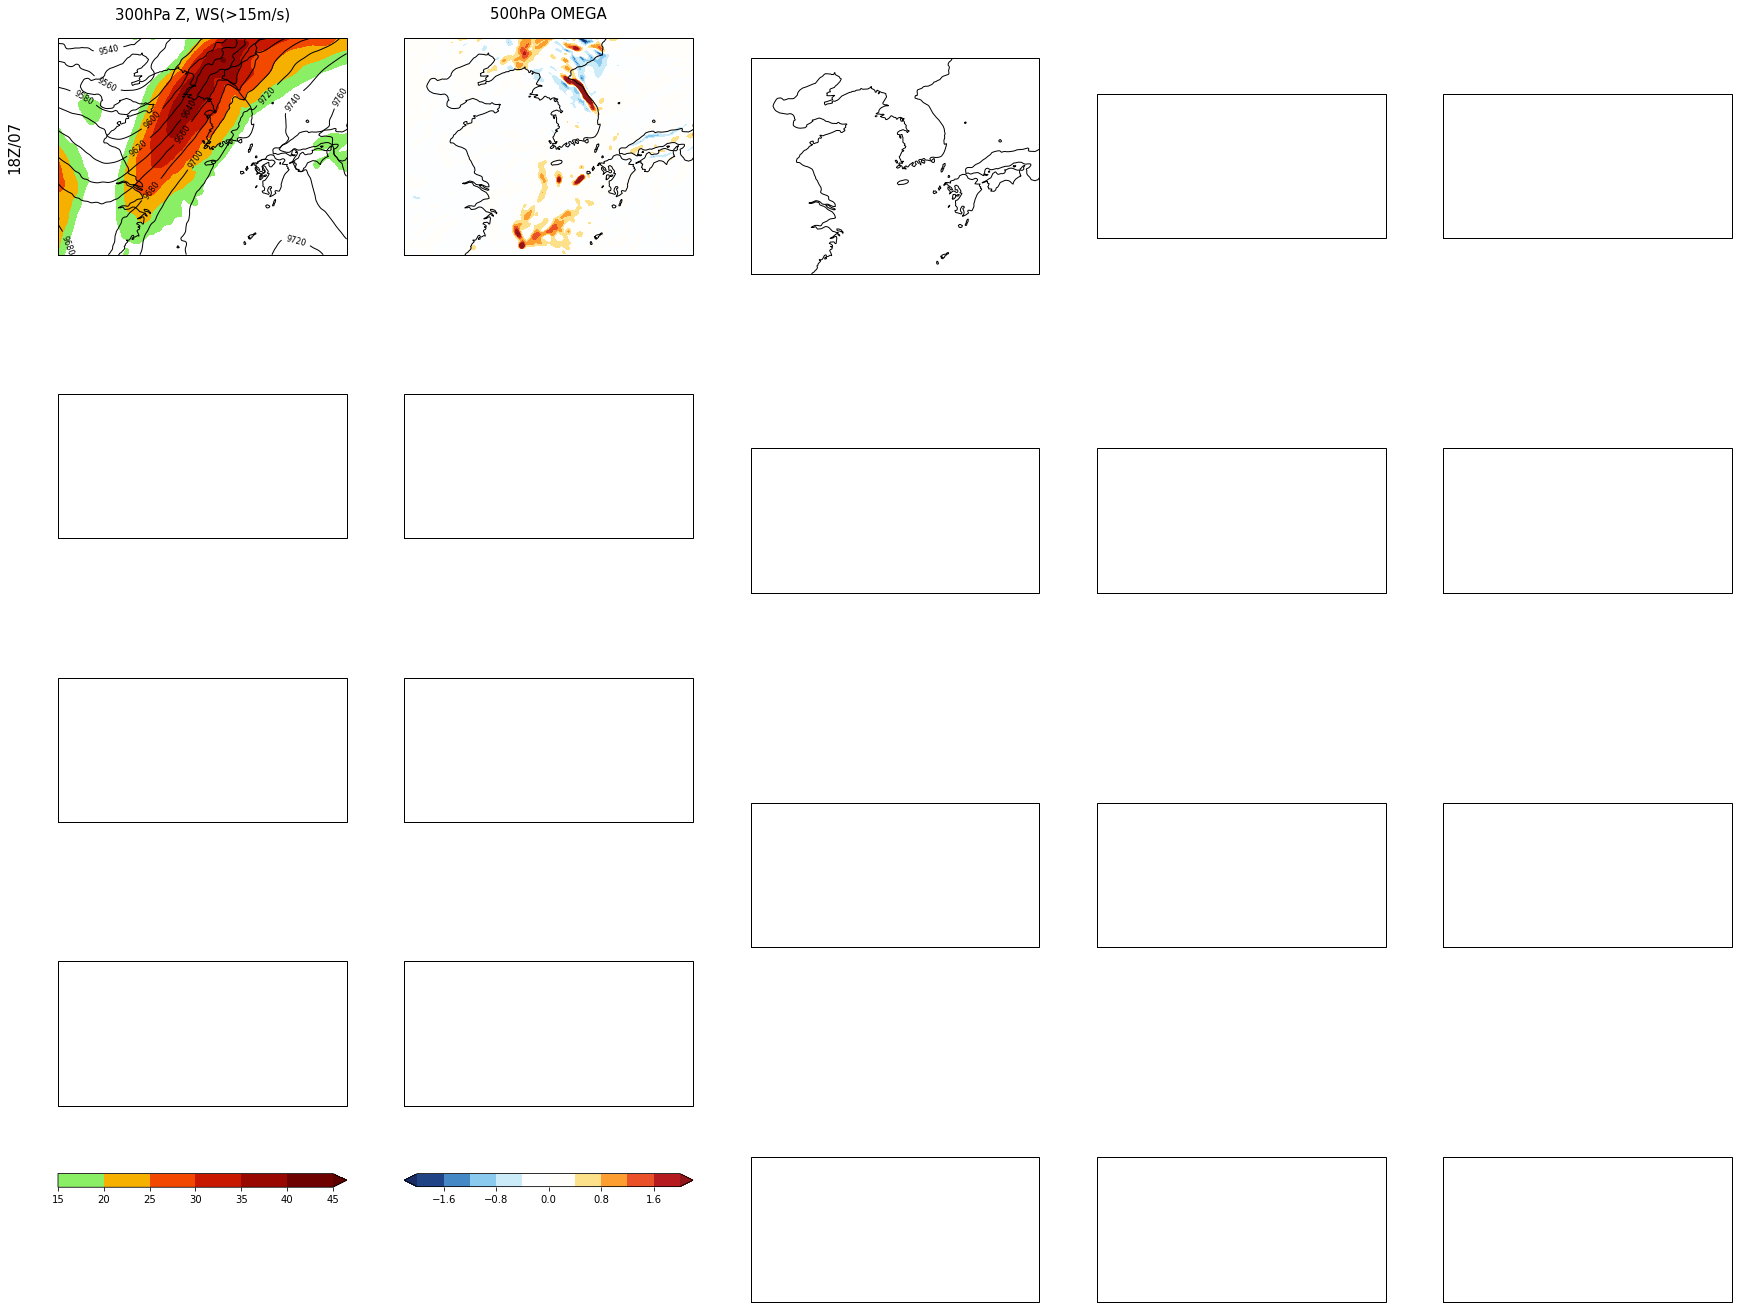

In [77]:
from matplotlib import ticker, cm

proj = ccrs.PlateCarree()
fig, axes = plt.subplots(4, 5, figsize=(30,25), constrained_layout=True, 
                        subplot_kw=dict(projection=proj))

ts = ds1
lat, lon = [ts.lat, ts.lon]
lats, lons = [np.tile(lat, (len(lon),1)).transpose(), np.tile(lon, (len(lat),1))]
ts['lats'] = xr.DataArray(lats, coords=ts.slp.isel(Time=0).coords)
ts['lons'] = xr.DataArray(lons, coords=ts.slp.isel(Time=0).coords)

#for i, t in enumerate(np.arange(18,42,6)):
for i, t in enumerate(np.arange(42,66,6)):
    for j, ax in enumerate(axes[i,:].flatten()):
        ax.coastlines(resolution='50m')
        ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()], crs=proj)

        if j==0:
            l = 14
            level = ts.level.isel(level=l).values
            title = "{}hPa Z, WS(>15m/s)".format(level, level)
            cs = ax.contourf(ts.lon, ts.lat, mpcalc.smooth_n_point(ts.isel(Time=t, level=l).wspd, 9), 
                              levels=np.arange(15,50,5), cmap=gvcmaps.hotres, extend='max')
            if i==0: fig.colorbar(cs, ax=axes[:,j], orientation='horizontal')
            
            cl=ax.contour(ts.lon, ts.lat, mpcalc.smooth_n_point(ts.isel(Time=t, level=l).z, 9), 
                          levels=12, linewidths=1, colors='k')
            ax.clabel(cl, fontsize=8, fmt='%d', inline=True)
            
        elif j==1:
            l=10
            level = ts.level.isel(level=l).values
            title = "{}hPa OMEGA".format(level)
            cs = ax.contourf(ts.lon, ts.lat, -mpcalc.smooth_n_point(ts.isel(Time=t, level=l).omg, 9), 
                     levels=np.arange(-1,1.2,0.2)*2, cmap=gvcmaps.BlueWhiteOrangeRed, extend='both')
            if i==0: fig.colorbar(cs, ax=axes[:,j], orientation='horizontal')
            
        elif j==2:
            l = 3
            level = ts.level.isel(level=l).values
            title = "{}hPa MFC*1e-6, surface FR (>5e-9)".format(level)
            cs = ax.contourf(ts.lon, ts.lat, ts.isel(Time=t, level=l).mfc*1e6, 
                             levels=np.arange(-1,1.2,0.2)*2, 
                             cmap=gvcmaps.BlueWhiteOrangeRed, extend='both')
            if i==0: fig.colorbar(cs, ax=axes[:,j], orientation='horizontal')
            
            cl = ax.contour(ts.lon, ts.lat, ts.isel(Time=t, level=0).fr*1e9, 
                            levels=[5], linewidths=1, colors='lime')
            
            #cl = ax.contour(ts.lon, ts.lat, ts.isel(Time=t, level=3).fr*1e9, 
            #                levels=[5], linewidths=1, colors='magenta')
            
            #cl = ax.contour(ts.lon, ts.lat, ts.isel(Time=t, level=10).fr*1e9, 
            #                levels=[5], linewidths=1, colors='gold')
            
            #skip = slice(None,None,1)
            #x = np.array(ts.lons.isel(lon=skip, lat=skip).values).flatten()
            #y = np.array(ts.lats.isel(lon=skip, lat=skip).values).flatten()
            #z = np.array(ts.isel(Time=t, level=l, lon=skip, lat=skip).fr.values).flatten()
            #mask = np.where(z>5e-9)
            #ax.scatter(x[mask], y[mask], marker='o', color='lime', s=5, alpha=0.5)
            
        elif j==3:
            eth2 = mpcalc.potential_temperature(ts.isel(Time=t).slp * units.hPa, 
                                                    ts.isel(Time=t).T2 * units.K)
            #eth2 = mpcalc.equivalent_potential_temperature(ts.isel(Time=t).slp * units.hPa, 
            #                                        ts.isel(Time=t).T2 * units.K, 
            #                                        ts.isel(Time=t).td2 * units.degC)
            eth2 = eth2.where(mask==0)
            
            dx, dy = mpcalc.lat_lon_grid_deltas(ts.lon * units("degrees_E"), ts.lat * units("degrees_N"))
            tmp = mpcalc.first_derivative(eth2 * units.K, axis=0, delta=dy)
            eth_grad_y = xr.DataArray(tmp, coords=eth2.coords, dims=eth2.dims)
            
            tmp = mpcalc.first_derivative(eth2 * units.K, axis=1, delta=dx)
            eth_grad_x = xr.DataArray(tmp, coords=eth2.coords, dims=eth2.dims)
            
            title = r"td2"
            cs = ax.contourf(ts.lon, ts.lat, (ts.T2-273.15-ts.td2).isel(Time=t).where(mask==0), 
                     levels=np.arange(0,5.2,0.2), cmap=gvcmaps.hotres, extend='both')
            tmp = (ts.T2-273.15-ts.td2).isel(Time=t).where(mask==0)
            tmp = tmp.where(tmp<0)
            print(tmp.max().values, tmp.min().values)
            if i==0: fig.colorbar(cs, ax=axes[:,j], orientation='horizontal')
            
        elif j==4:
            l = 3
            tmp = mpcalc.first_derivative(ts.eth.isel(Time=t)*units.K, x=ts.z.isel(Time=t)*units.meter, axis=0)
            eth_grad_z = xr.DataArray(tmp, coords=ts.z.isel(Time=t).coords, dims=ts.z.isel(Time=t).dims)
            
            dx, dy = mpcalc.lat_lon_grid_deltas(ts.lon * units("degrees_E"), ts.lat * units("degrees_N"))
            td2 = ts.isel(Time=t).td2.where(mask==0)
            td2_adv = mpcalc.advection(scalar=td2 * units['degC'], 
                                       u=ts.isel(Time=t).U10 * units['m/s'], 
                                       v=ts.isel(Time=t).V10 * units['m/s'],
                                       dx=dx, dy=dy)
            
            hskip=slice(None,None,5)
            u=mpcalc.smooth_n_point(ts.isel(Time=t).U10, 9)
            v=mpcalc.smooth_n_point(ts.isel(Time=t).V10, 9)
                                    
            title = r"td2_adv"
            sh2 = mpcalc.specific_humidity_from_dewpoint(pressure=ts.slp * units.hPa, dewpoint=ts.td2 * units.degC)
            print( ts.rh2.isel(Time=t).where(mask==0).max())
            cs = ax.contourf(ts.lon, ts.lat, ts.rh2.isel(Time=t).where(mask==0), 
                             levels=np.arange(70,104,2), cmap=gvcmaps.hotres_r, extend='both')
            #cs = ax.contourf(ts.lon, ts.lat, td2_adv*10000, levels=np.arange(-5,6,1),
            #                 cmap=gvcmaps.BlueWhiteOrangeRed, extend='both')
            #cs = ax.contourf(ts.lon, ts.lat, eth_grad_z.isel(level=slice(0,2)).mean(axis=0)*1000, levels=np.arange(-10,12,2)*2,
            #                 cmap=gvcmaps.BlueWhiteOrangeRed, extend='both')
            if i==0: fig.colorbar(cs, ax=axes[:,j], orientation='horizontal')
            #cl = ax.contour(ts.lon, ts.lat, ts.isel(Time=t).slp, linewidths=1, colors='k')
            #ax.clabel(cl, fontsize=8, fmt='%d', inline=True)
            #Q = ax.quiver(ts.lon[hskip], ts.lat[hskip], u[hskip,hskip], v[hskip,hskip],
            #       color='black', pivot="middle", width=0.005, scale=100)
            
        if i==0:
            ax.set_title(title, fontsize=15, pad=20)
            
        if j==0: 
            ax.text(-0.15, 0.5, ts['Time'].isel(Time=t).dt.strftime("%HZ/%d").values, 
                    fontsize=15, va='center', ha='center', rotation=90, transform=ax.transAxes)

#fig.colorbar(cs1, ax=axes[:,0], orientation='horizontal')
#fig.colorbar(cs2, ax=axes[:,1], orientation='horizontal')
#fig.colorbar(cs3, ax=axes[:,2], orientation='horizontal')
#fig.colorbar(cs4, ax=axes[:,3], orientation='horizontal')
#fig.colorbar(cs5, ax=axes[:,4], orientation='horizontal')

### CPL_down minus CPL_nodown

/home/siyang/miniconda3/envs/wrf_tutorial/lib/python3.8/site-packages/IPython/core/pylabtools.py:137: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)
/home/siyang/miniconda3/envs/wrf_tutorial/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:387: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  return matplotlib.axes.Axes.draw(self, renderer=renderer,


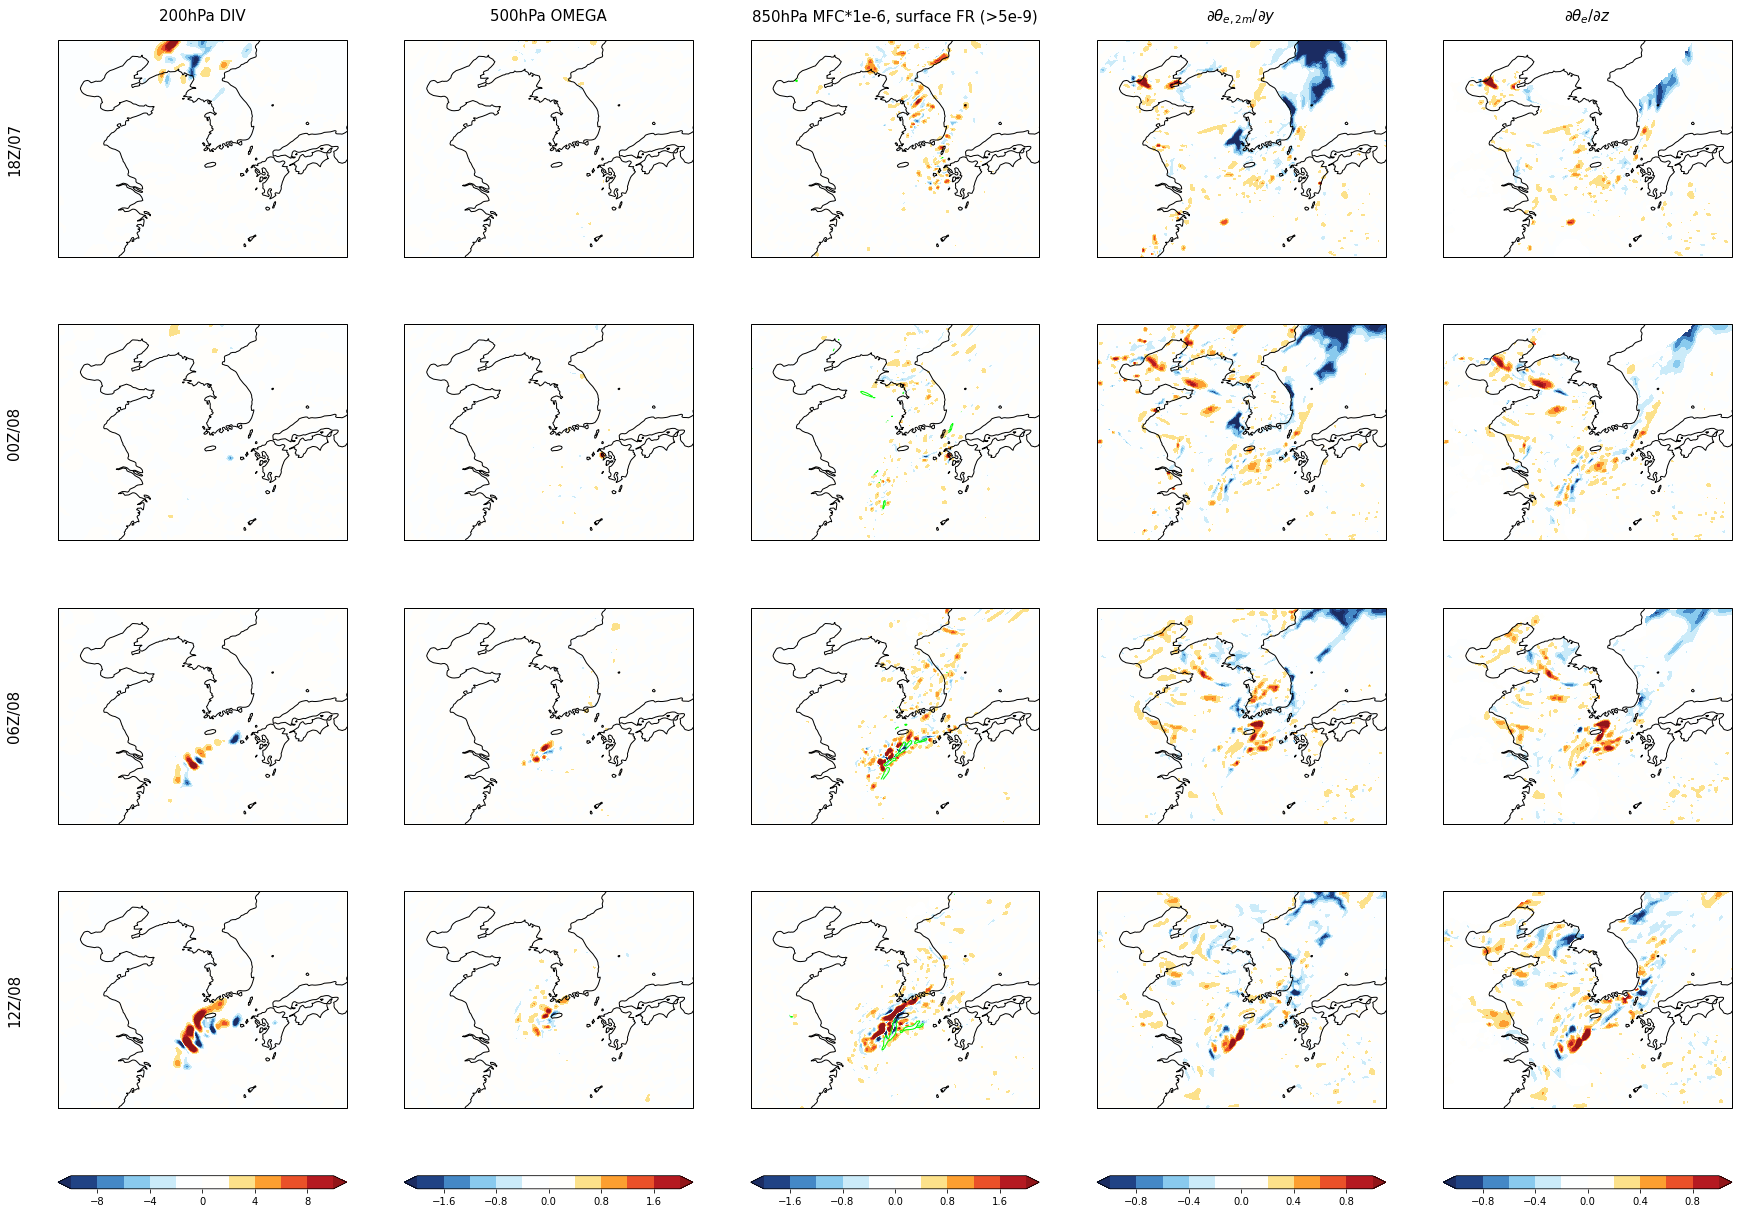

In [700]:
from matplotlib import ticker, cm

proj = ccrs.PlateCarree()
fig, axes = plt.subplots(4, 5, figsize=(30,25), constrained_layout=True, 
                        subplot_kw=dict(projection=proj))

ts = ds32
lat, lon = [ts.lat, ts.lon]
lats, lons = [np.tile(lat, (len(lon),1)).transpose(), np.tile(lon, (len(lat),1))]
ts['lats'] = xr.DataArray(lats, coords=ts.slp.isel(Time=0).coords)
ts['lons'] = xr.DataArray(lons, coords=ts.slp.isel(Time=0).coords)

#for i, t in enumerate(np.arange(18,42,6)):
for i, t in enumerate(np.arange(42,66,6)):
    for j, ax in enumerate(axes[i,:].flatten()):
        ax.coastlines(resolution='50m')
        ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()], crs=proj)

        if j==0:
            l = 16
            level = ts.level.isel(level=l).values
            title = "{}hPa DIV".format(level, level)
            cs = ax.contourf(ts.lon, ts.lat, mpcalc.smooth_n_point(ts.isel(Time=t, level=l).accrain_12h, 9), 
                              levels=np.arange(-10,12,2), cmap=gvcmaps.BlueWhiteOrangeRed, extend='both')
            if i==0: fig.colorbar(cs, ax=axes[:,j], orientation='horizontal')
            
            #cl=ax.contour(ts.lon, ts.lat, mpcalc.smooth_n_point(ts.isel(Time=t, level=l).z, 9), 
            #              levels=12, linewidths=1, colors='k')
            #ax.clabel(cl, fontsize=8, fmt='%d', inline=True)
            
        elif j==1:
            l=10
            level = ts.level.isel(level=l).values
            title = "{}hPa OMEGA".format(level)
            cs = ax.contourf(ts.lon, ts.lat, -mpcalc.smooth_n_point(ts.isel(Time=t, level=l).omg, 9), 
                     levels=np.arange(-1,1.2,0.2)*2, cmap=gvcmaps.BlueWhiteOrangeRed, extend='both')
            if i==0: fig.colorbar(cs, ax=axes[:,j], orientation='horizontal')
            
        elif j==2:
            l = 3
            level = ts.level.isel(level=l).values
            title = "{}hPa MFC*1e-6, surface FR (>5e-9)".format(level)
            cs = ax.contourf(ts.lon, ts.lat, ts.isel(Time=t, level=l).mfc*1e6, 
                             levels=np.arange(-1,1.2,0.2)*2, 
                             cmap=gvcmaps.BlueWhiteOrangeRed, extend='both')
            if i==0: fig.colorbar(cs, ax=axes[:,j], orientation='horizontal')
            
            cl = ax.contour(ts.lon, ts.lat, ts.isel(Time=t, level=0).fr*1e9, 
                            levels=[5], linewidths=1, colors='lime')
            
        elif j==3:
            
            eth2 = mpcalc.potential_temperature(ds3.isel(Time=t).slp * units.hPa, 
                                                    ds3.isel(Time=t).T2 * units.K)
            #eth2 = mpcalc.equivalent_potential_temperature(ds3.isel(Time=t).slp * units.hPa, 
            #                                        ds3.isel(Time=t).T2 * units.K, 
            #                                        ds3.isel(Time=t).td2 * units.degC)
            eth2 = eth2.where(mask==0)
            th3 = eth2
            
            dx, dy = mpcalc.lat_lon_grid_deltas(ts.lon * units("degrees_E"), ts.lat * units("degrees_N"))
            tmp = mpcalc.first_derivative(eth2 * units.K, axis=0, delta=dy)
            eth_grad_y3 = xr.DataArray(tmp, coords=eth2.coords, dims=eth2.dims)
            
            eth2 = mpcalc.potential_temperature(ds2.isel(Time=t).slp * units.hPa, 
                                                    ds2.isel(Time=t).T2 * units.K)
            #eth2 = mpcalc.equivalent_potential_temperature(ds2.isel(Time=t).slp * units.hPa, 
            #                                        ds2.isel(Time=t).T2 * units.K, 
            #                                        ds2.isel(Time=t).td2 * units.degC)
            eth2 = eth2.where(mask==0)
            th2 = eth2
            
            dx, dy = mpcalc.lat_lon_grid_deltas(ts.lon * units("degrees_E"), ts.lat * units("degrees_N"))
            tmp = mpcalc.first_derivative(eth2 * units.K, axis=0, delta=dy)
            eth_grad_y2 = xr.DataArray(tmp, coords=eth2.coords, dims=eth2.dims)
            
            eth_grad_y = eth_grad_y3-eth_grad_y2
            th = th3-th2
            
            title = r"$\partial \theta_{e,2m}/ \partial y$"
            #cs = ax.contourf(ts.lon, ts.lat, (eth_grad_y)*10000, 
            #         levels=np.arange(-10,12,2)/50, cmap=gvcmaps.BlueWhiteOrangeRed, extend='both')
            cs = ax.contourf(ts.lon, ts.lat, ts.td2.isel(Time=t), 
                     levels=np.arange(-10,12,2)/10, cmap=gvcmaps.BlueWhiteOrangeRed, extend='both')
            #lh = ts.isel(Time=t).LH.where(ds3.isel(Time=t).LH<0)
            #cs = ax.contourf(ts.lon, ts.lat, lh,
            #         levels=np.arange(-10,12,2), cmap=gvcmaps.BlueWhiteOrangeRed, extend='both')
            if i==0: fig.colorbar(cs, ax=axes[:,j], orientation='horizontal')
            
        elif j==4:
            l = 3
            tmp = mpcalc.first_derivative(ds3.eth.isel(Time=t)*units.K, x=ds3.z.isel(Time=t)*units.meter, axis=0)
            eth_grad_z3 = xr.DataArray(tmp, coords=ts.z.isel(Time=t).coords, dims=ts.z.isel(Time=t).dims)
            
            tmp = mpcalc.first_derivative(ds2.eth.isel(Time=t)*units.K, x=ds2.z.isel(Time=t)*units.meter, axis=0)
            eth_grad_z2 = xr.DataArray(tmp, coords=ts.z.isel(Time=t).coords, dims=ts.z.isel(Time=t).dims)
            
            eth_grad_z = eth_grad_z3-eth_grad_z2
                        
            title = r"$\partial \theta_{e}/ \partial z$"
            #cs = ax.contourf(ts.lon, ts.lat, eth_grad_z.isel(level=0)*1000, levels=np.arange(-8,10,2),
            #                 cmap=gvcmaps.BlueWhiteOrangeRed, extend='both')
            cs = ax.contourf(ts.lon, ts.lat, ts.td.isel(Time=t,level=0), levels=np.arange(-10,12,2)/10,
                             cmap=gvcmaps.BlueWhiteOrangeRed, extend='both')
            if i==0: fig.colorbar(cs, ax=axes[:,j], orientation='horizontal')
            #cl = ax.contour(ts.lon, ts.lat, ts.isel(Time=t).slp, linewidths=1, colors='k')
            #ax.clabel(cl, fontsize=8, fmt='%d', inline=True)
            
            
        if i==0:
            ax.set_title(title, fontsize=15, pad=20)
            
        if j==0: 
            ax.text(-0.15, 0.5, ts['Time'].isel(Time=t).dt.strftime("%HZ/%d").values, 
                    fontsize=15, va='center', ha='center', rotation=90, transform=ax.transAxes)

#fig.colorbar(cs1, ax=axes[:,0], orientation='horizontal')
#fig.colorbar(cs2, ax=axes[:,1], orientation='horizontal')
#fig.colorbar(cs3, ax=axes[:,2], orientation='horizontal')
#fig.colorbar(cs4, ax=axes[:,3], orientation='horizontal')
#fig.colorbar(cs5, ax=axes[:,4], orientation='horizontal')

In [ ]:
proj = ccrs.PlateCarree()
fig, axes = plt.subplots(5, 5, figsize=(30,20), constrained_layout=True, 
                        subplot_kw=dict(projection=proj))

l = 14
ts = ds3

#[42, 48, 54, 60, 66]
for i, t in enumerate(np.arange(36,66,6)):
#for i, t in enumerate(np.arange(0,30,6)):
    for j, ax in enumerate(axes[:,i].flatten()):
        ax.coastlines(resolution='50m')
        ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()], crs=proj)

        if j==0:
            l = 14
            level = ts.level.isel(level=l).values
            title = "WS{} & Z{}".format(level, level)
            cs1 = ax.contourf(ts.lon, ts.lat, mpcalc.smooth_n_point(ts.isel(Time=t, level=l).wspd, 9), 
                              levels=np.arange(15,50,5), cmap=gvcmaps.hotres, extend='max')
            
            cl=ax.contour(ts.lon, ts.lat, mpcalc.smooth_n_point(ts.isel(Time=t, level=l).z, 9), 
                          levels=12, colors='k')
            ax.clabel(cl, fontsize=8, fmt='%d', inline=True)
            
            ax.set_title(ts['Time'].isel(Time=t).dt.strftime("%HZ %b %d, %Y").values, fontsize=12)
            
        elif j==1:
            title = "SLP & RAIN"
            cs2 = ax.contourf(ts.lon, ts.lat, mpcalc.smooth_n_point(ts.isel(Time=t).rain, 9), clevs, cmap=cmap, norm=norm)
            cl = ax.contour(ds1.lon, ds1.lat, ds3.isel(Time=t).slp, colors='k')
            ax.clabel(cl, fontsize=8, fmt='%d', inline=True)
            
        elif j==2:
            l = 3
            level = ts.level.isel(level=l).values
            title = "MF & MFC{}".format(level)
            cs3 = ax.contourf(ts.lon, ts.lat, mpcalc.smooth_n_point(ts.isel(Time=t, level=l).mfc*1e6, 9), 
                     levels=np.arange(-1,1.2,0.2)*2, cmap=gvcmaps.BlueWhiteOrangeRed, extend='both')
            cl=ax.contour(ts.lon, ts.lat, mpcalc.smooth_n_point(ts.isel(Time=t, level=l).z, 9), 
                          levels=12, colors='k')
            
        elif j==3:
            l = 1
            level = ts.level.isel(level=l).values
            title = "FR{}".format(level)
            cs4 = ax.contourf(ts.lon, ts.lat, mpcalc.smooth_n_point(ts.isel(Time=t, level=l).fr*1e9, 9), 
                     levels=np.arange(-1,1.2,0.2)*5, cmap=gvcmaps.BlueWhiteOrangeRed, extend='both')
            cl=ax.contour(ts.lon, ts.lat, mpcalc.smooth_n_point(ts.isel(Time=t, level=l).z, 9), 
                          levels=12, colors='k')
            
        elif j==4:
            l=0
            title = "ETH"
            #dx, dy = mpcalc.lat_lon_grid_deltas(ts.lon * units("degrees_E"), ts.lat * units("degrees_N"))
            #eth2_adv = mpcalc.advection(scalar=ts.th.isel(Time=t, level=l), 
            #                    u=ts.ua.isel(Time=t, level=l) * units['m/s'], 
            #                    v=ts.ua.isel(Time=t, level=l) * units['m/s'],
            #                    dx=dx, dy=dy)
            cs5 = ax.contourf(ts.lon, ts.lat, mpcalc.smooth_n_point(ts.isel(Time=t, level=l).eth, 9), 
                     levels=12, cmap=gvcmaps.BlueWhiteOrangeRed, extend='both')
                
        if i==0: 
            ax.text(-0.075, 0.5, title, fontsize=12, va='center', ha='center', rotation=90, transform=ax.transAxes)
            
fig.colorbar(cs1, ax=axes[0,:])
fig.colorbar(cs2, ax=axes[1,:])
fig.colorbar(cs3, ax=axes[2,:])
fig.colorbar(cs4, ax=axes[3,:])
fig.colorbar(cs5, ax=axes[4,:])